# Setup step - Imports and directory setup

In [1]:
import os
import pickle
import numpy as np
if not os.path.basename(os.getcwd()) in ["nas", "ea-nas", "EA-architecture-search"]:
    os.chdir("../")
print(f"Current workdirectory: {os.getcwd()}")

import matplotlib
import matplotlib.pyplot as plt

from src.configuration import Configuration
from LAB.simulation import Simulation

# This directory should contain the direct simulation results within a subdir:
storage_dir = r"/Users/magnus/Desktop/Results"

# Defining the sub-dirs:
config_dir = f"{storage_dir}/configs"
results_dir = f"{storage_dir}/results"

for directory in [storage_dir, config_dir, results_dir]:
    if not os.path.isdir(directory):
        print(f"ERROR: {directory} is not a directory")

Current workdirectory: /Users/magnus/Projects/Python/nas


In [2]:
params = {
    'figure.figsize': (50,30),
    'legend.fontsize': '52',
    'axes.labelsize': '52',
    'axes.titlesize': '72',
    'xtick.labelsize': '42',
    'ytick.labelsize': '42',
    'lines.linewidth': '7'      
}
plt.rcParams.update(params)
plt.rcParams.update(params)

# Setting up one experiment for analysis: 

In [3]:
exp01 = Simulation.read_all_genotypes_per_generation(config_dir, results_dir, "exp01")
exp02 = Simulation.read_all_genotypes_per_generation(config_dir, results_dir, "exp02")
exp03 = Simulation.read_all_genotypes_per_generation(config_dir, results_dir, "exp03")
exp04 = Simulation.read_all_genotypes_per_generation(config_dir, results_dir, "exp04")
exp05 = Simulation.read_all_genotypes_per_generation(config_dir, results_dir, "exp05")
exp06 = Simulation.read_all_genotypes_per_generation(config_dir, results_dir, "exp01-no-tl")

Loading exp01
 - Reading files, 100% complete			
 - population sorted into generations
Loading exp02
 - Reading files, 100% complete			
 - population sorted into generations
Loading exp03
 - Reading files, 100% complete			
 - population sorted into generations
Loading exp04
 - Reading files, 78% complete			
 - population sorted into generations
Loading exp05
 - Reading files, 100% complete			
 - population sorted into generations
Loading exp01-no-tl
 - Reading files, 100% complete			
 - population sorted into generations


In [4]:
exp01.name = "Baseline"
exp02.name = "Classifer task MOO"
exp03.name = "Architectural MOO"
exp04.name = "Patterns"
exp05.name = "Local"
exp06.name = "Baseline w/o TL"
experiments = [exp01, exp02, exp03, exp04, exp05, exp06]

In [5]:
def savedir(title): 
    title = "-".join(title.split())
    title = "-".join(title.split("/"))
    return os.path.join(storage_dir, f"plots/{title}.png")

def plot_setup(ax, title, xaxis_title=None, yaxis_title=None, legend=True, percent=False, ylim=None):
    ax.set_title(title, y=1.04)
    if percent:
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    if xaxis_title: 
        ax.set_xlabel(xaxis_title)
    if yaxis_title: 
        ax.set_ylabel(yaxis_title)
    if legend: 
        ax.legend()
    if ylim:
        ax.set_ylim(ylim)

def plotter(x, y, labels, title, xaxis_title=None, yaxis_title=None, legend=True, percent=False, ylim=None):
    ax = plt.subplot(111)
    if len(x) != len(y):
        y = [y]*len(x)
    for i in range(len(x)):
        plt.plot(y[i], x[i], label=labels[i])
    plot_setup(ax, title, xaxis_title, yaxis_title, legend=legend, percent=percent, ylim=ylim)
    plt.plot()
    plt.savefig(savedir(title))

# Looking at statistics for each generation

We are starting with accuracies for the test set.

In [6]:
def generations_to_hours(exp, hours=72):
    return [(i / len(exp.max_test_acc)) * hours for i in range(len(exp.max_test_acc))]

In [7]:
def plot_avg_acc_all_experiments(experiments, title="Top Accuracy Reached Per Experiment"):
    ax = plt.subplot(111)
    for exp in experiments:
        y = generations_to_hours(exp)
        plt.plot(y, exp.max_test_acc, label=exp.name)
        
    plot_setup(ax, title, xaxis_title="Hours elapsed since start", yaxis_title="Test set accuracy")
    ax.set_ylim(0.3, 1.0)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.plot()
    plt.savefig(savedir(title))

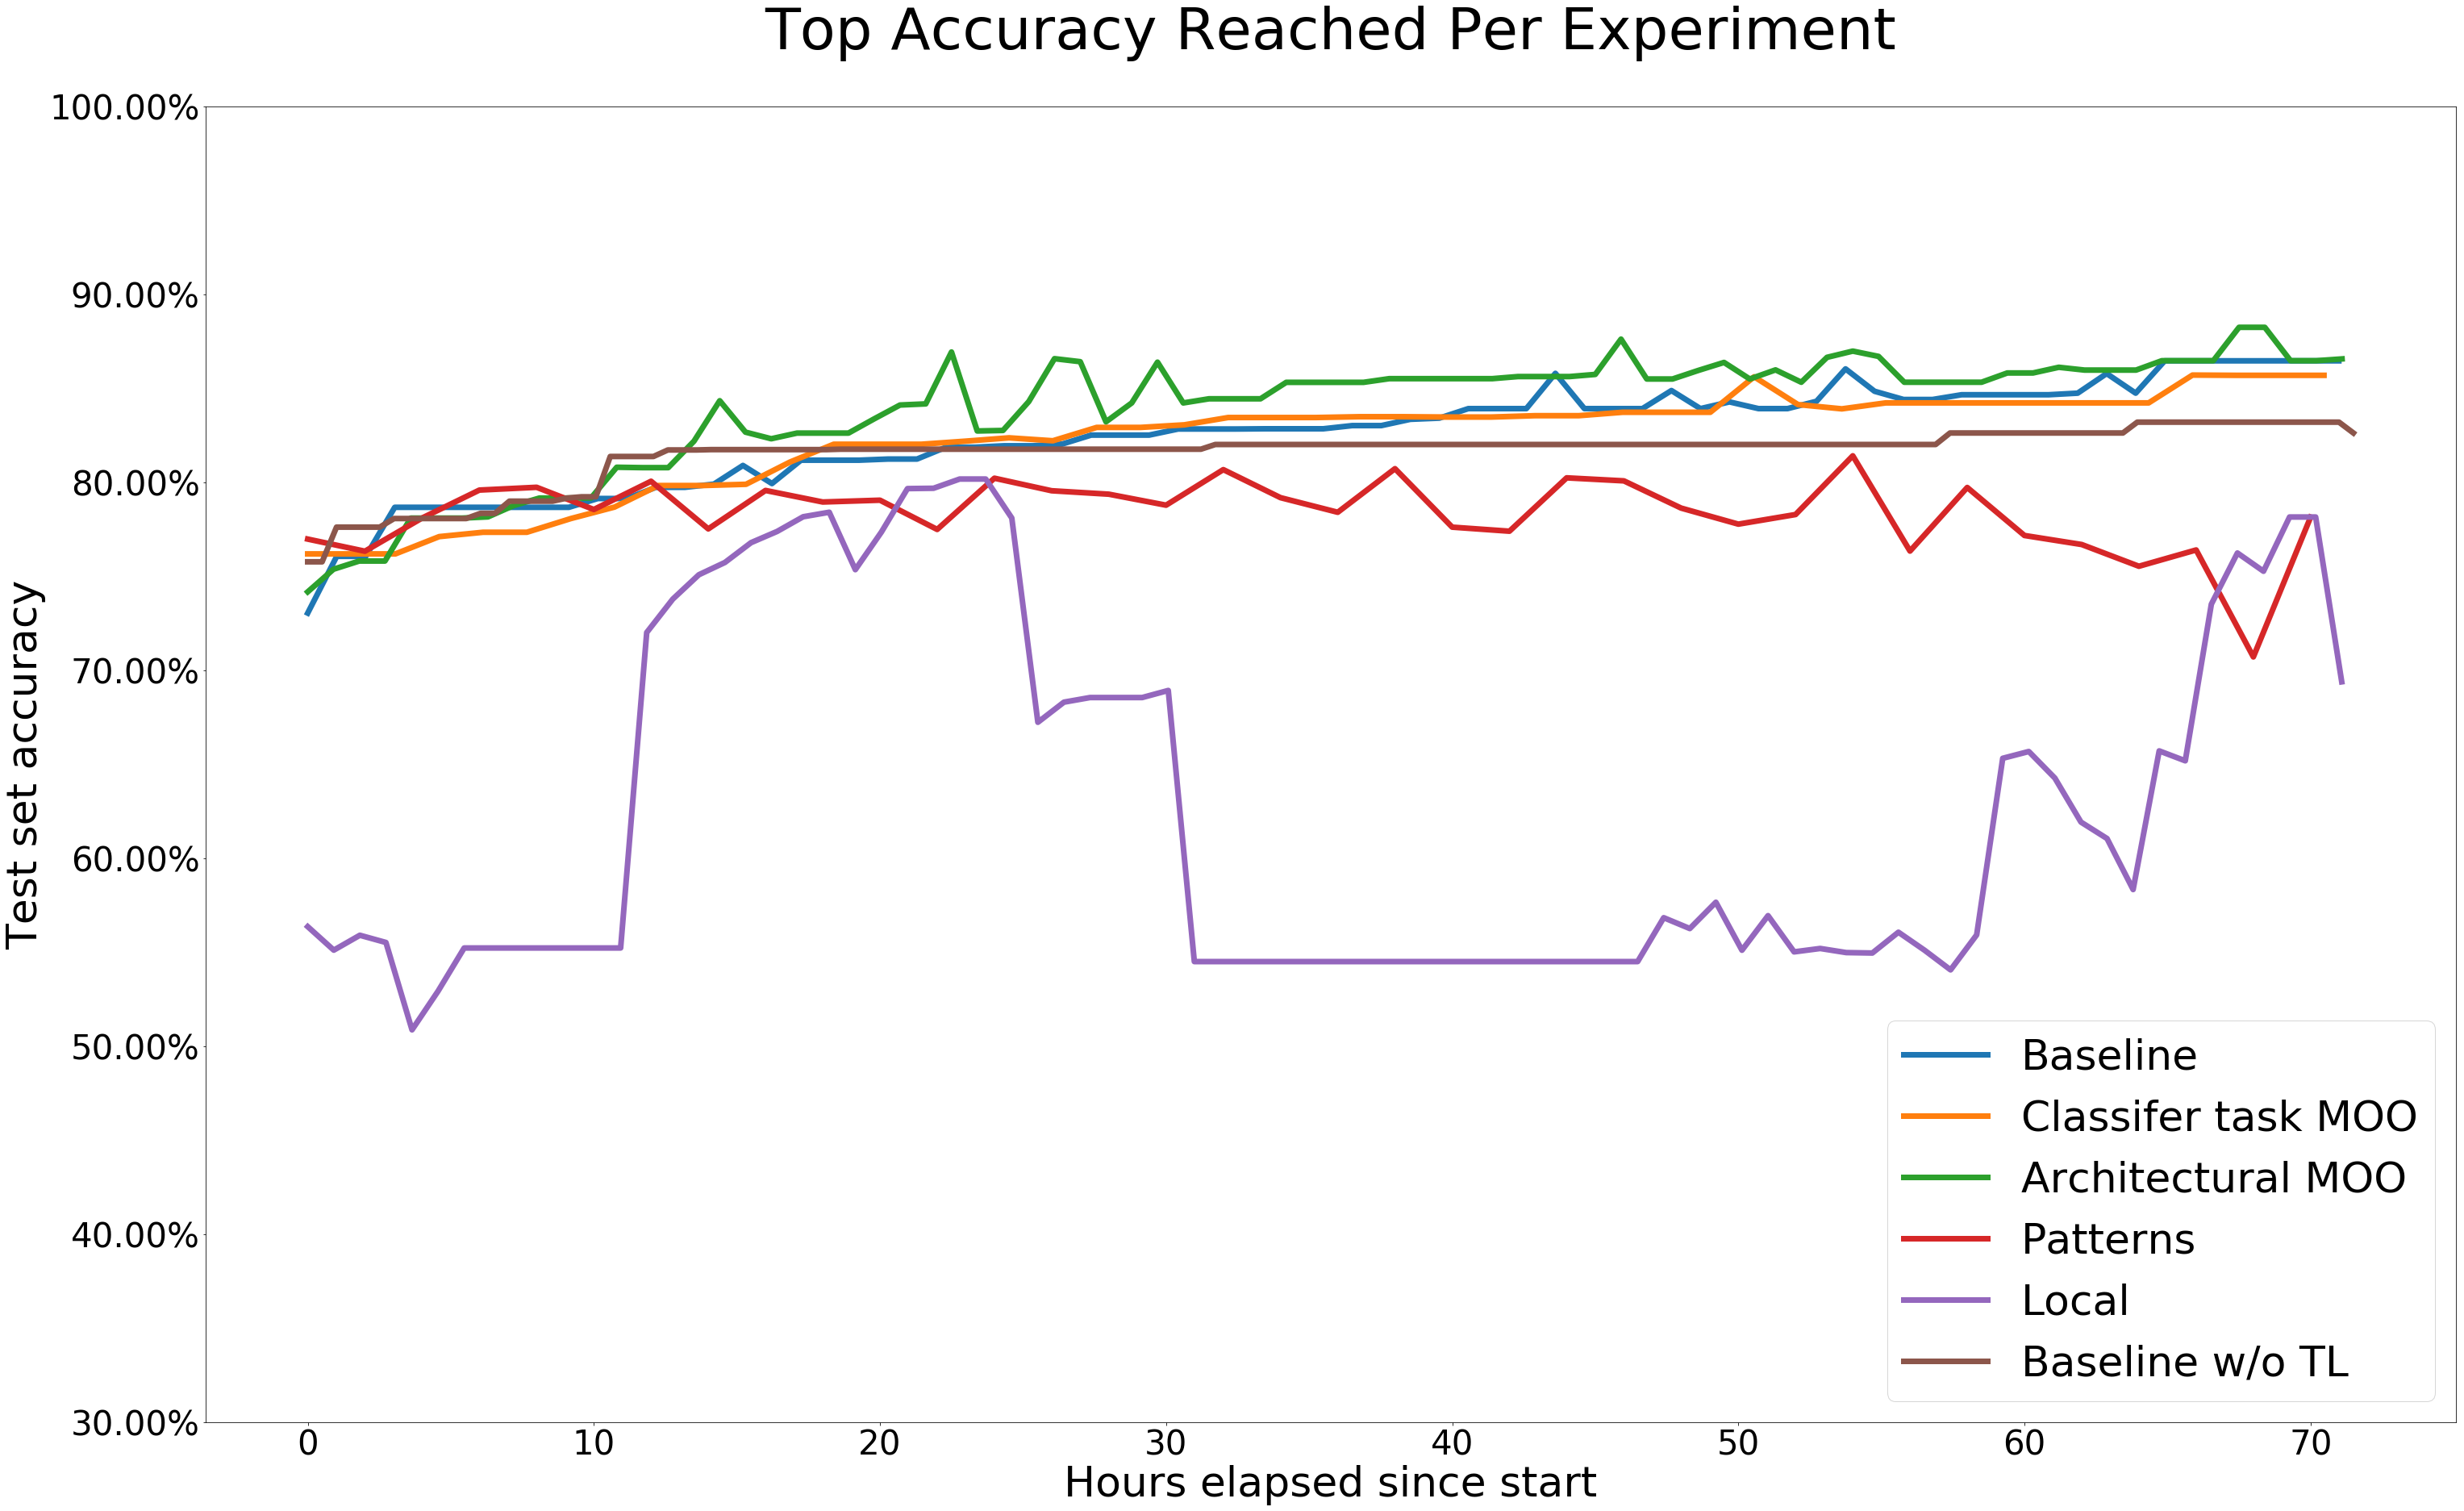

In [8]:
plot_avg_acc_all_experiments(experiments)

In [9]:
def plot_acc(exp, title="Min - Max - Average test accuracies"):
    title = f"{title} ({exp.name})"
    gens = generations_to_hours(exp)
    plotter(
        x=[
            exp.max_test_acc,
            exp.avg_test_acc,
            exp.min_test_acc
        ], 
        y=gens, 
        labels=[
            "Maximum test accuracy",
            "Average test accuracy",
            "Minimum test accuracy"
        ], 
        title=title,
        percent=True,
        xaxis_title="Hours elapsed since start",
        yaxis_title="Test set accuracy"
    )

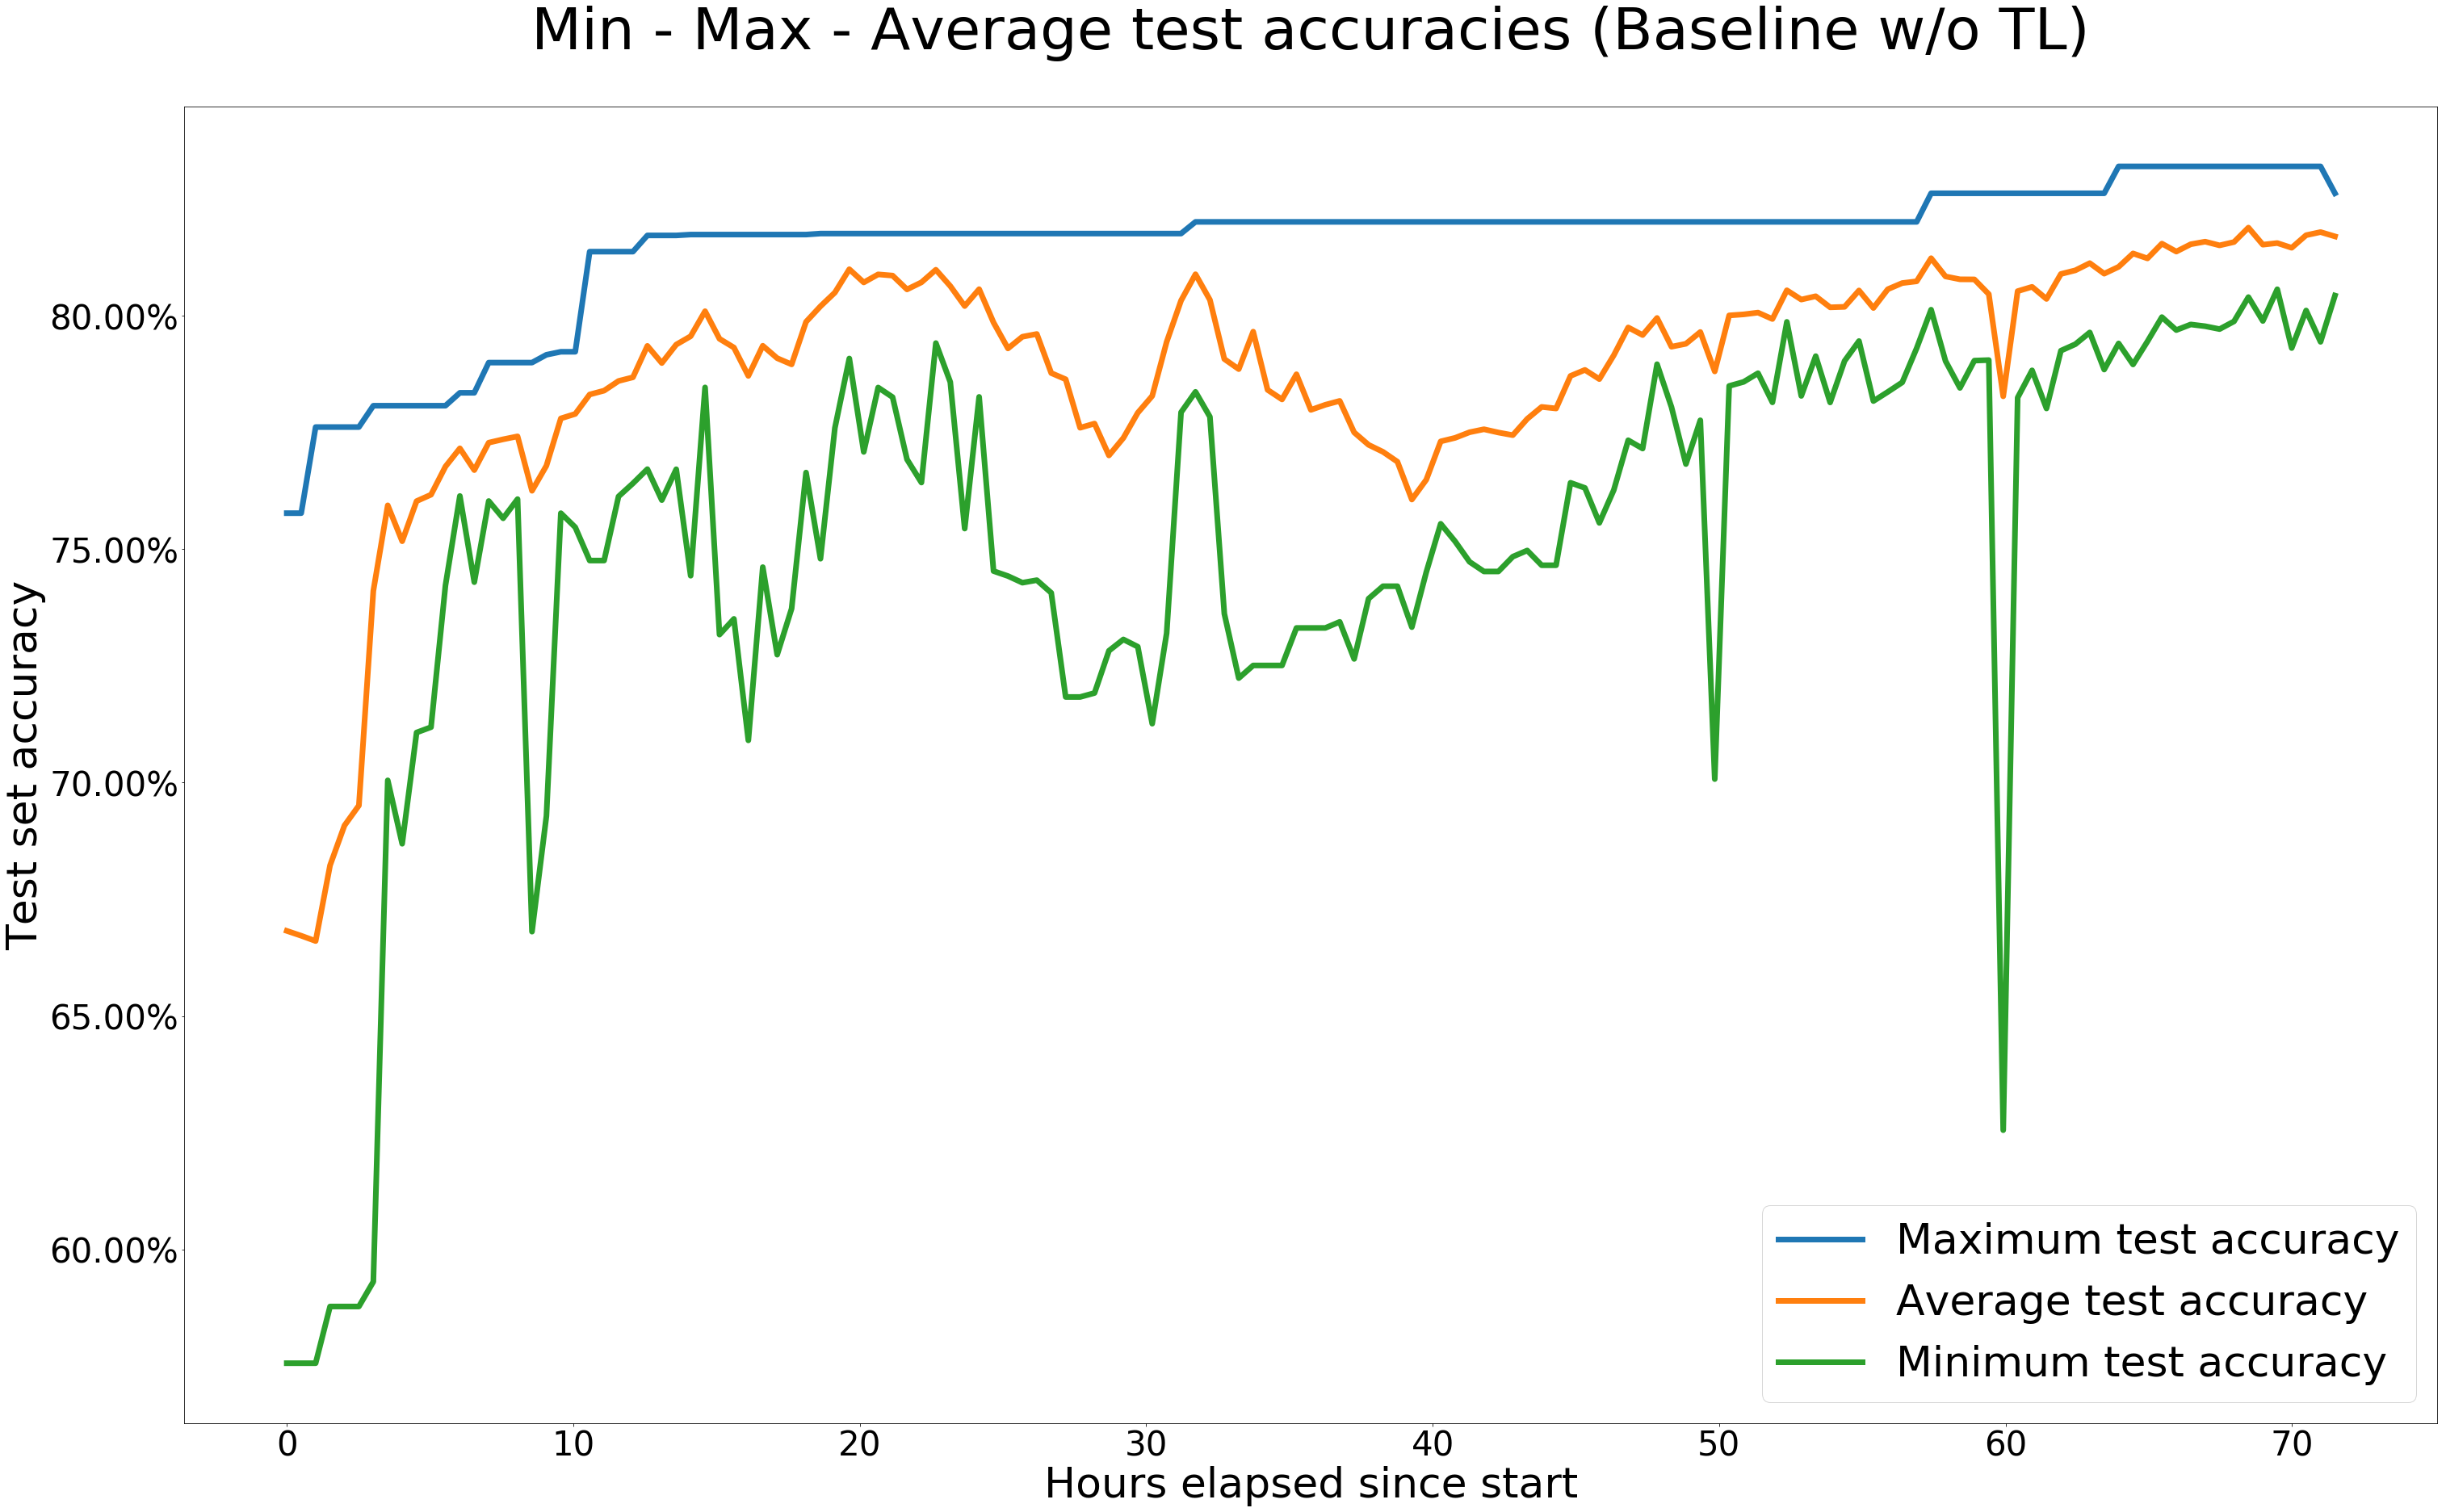

In [10]:
plot_acc(exp06)

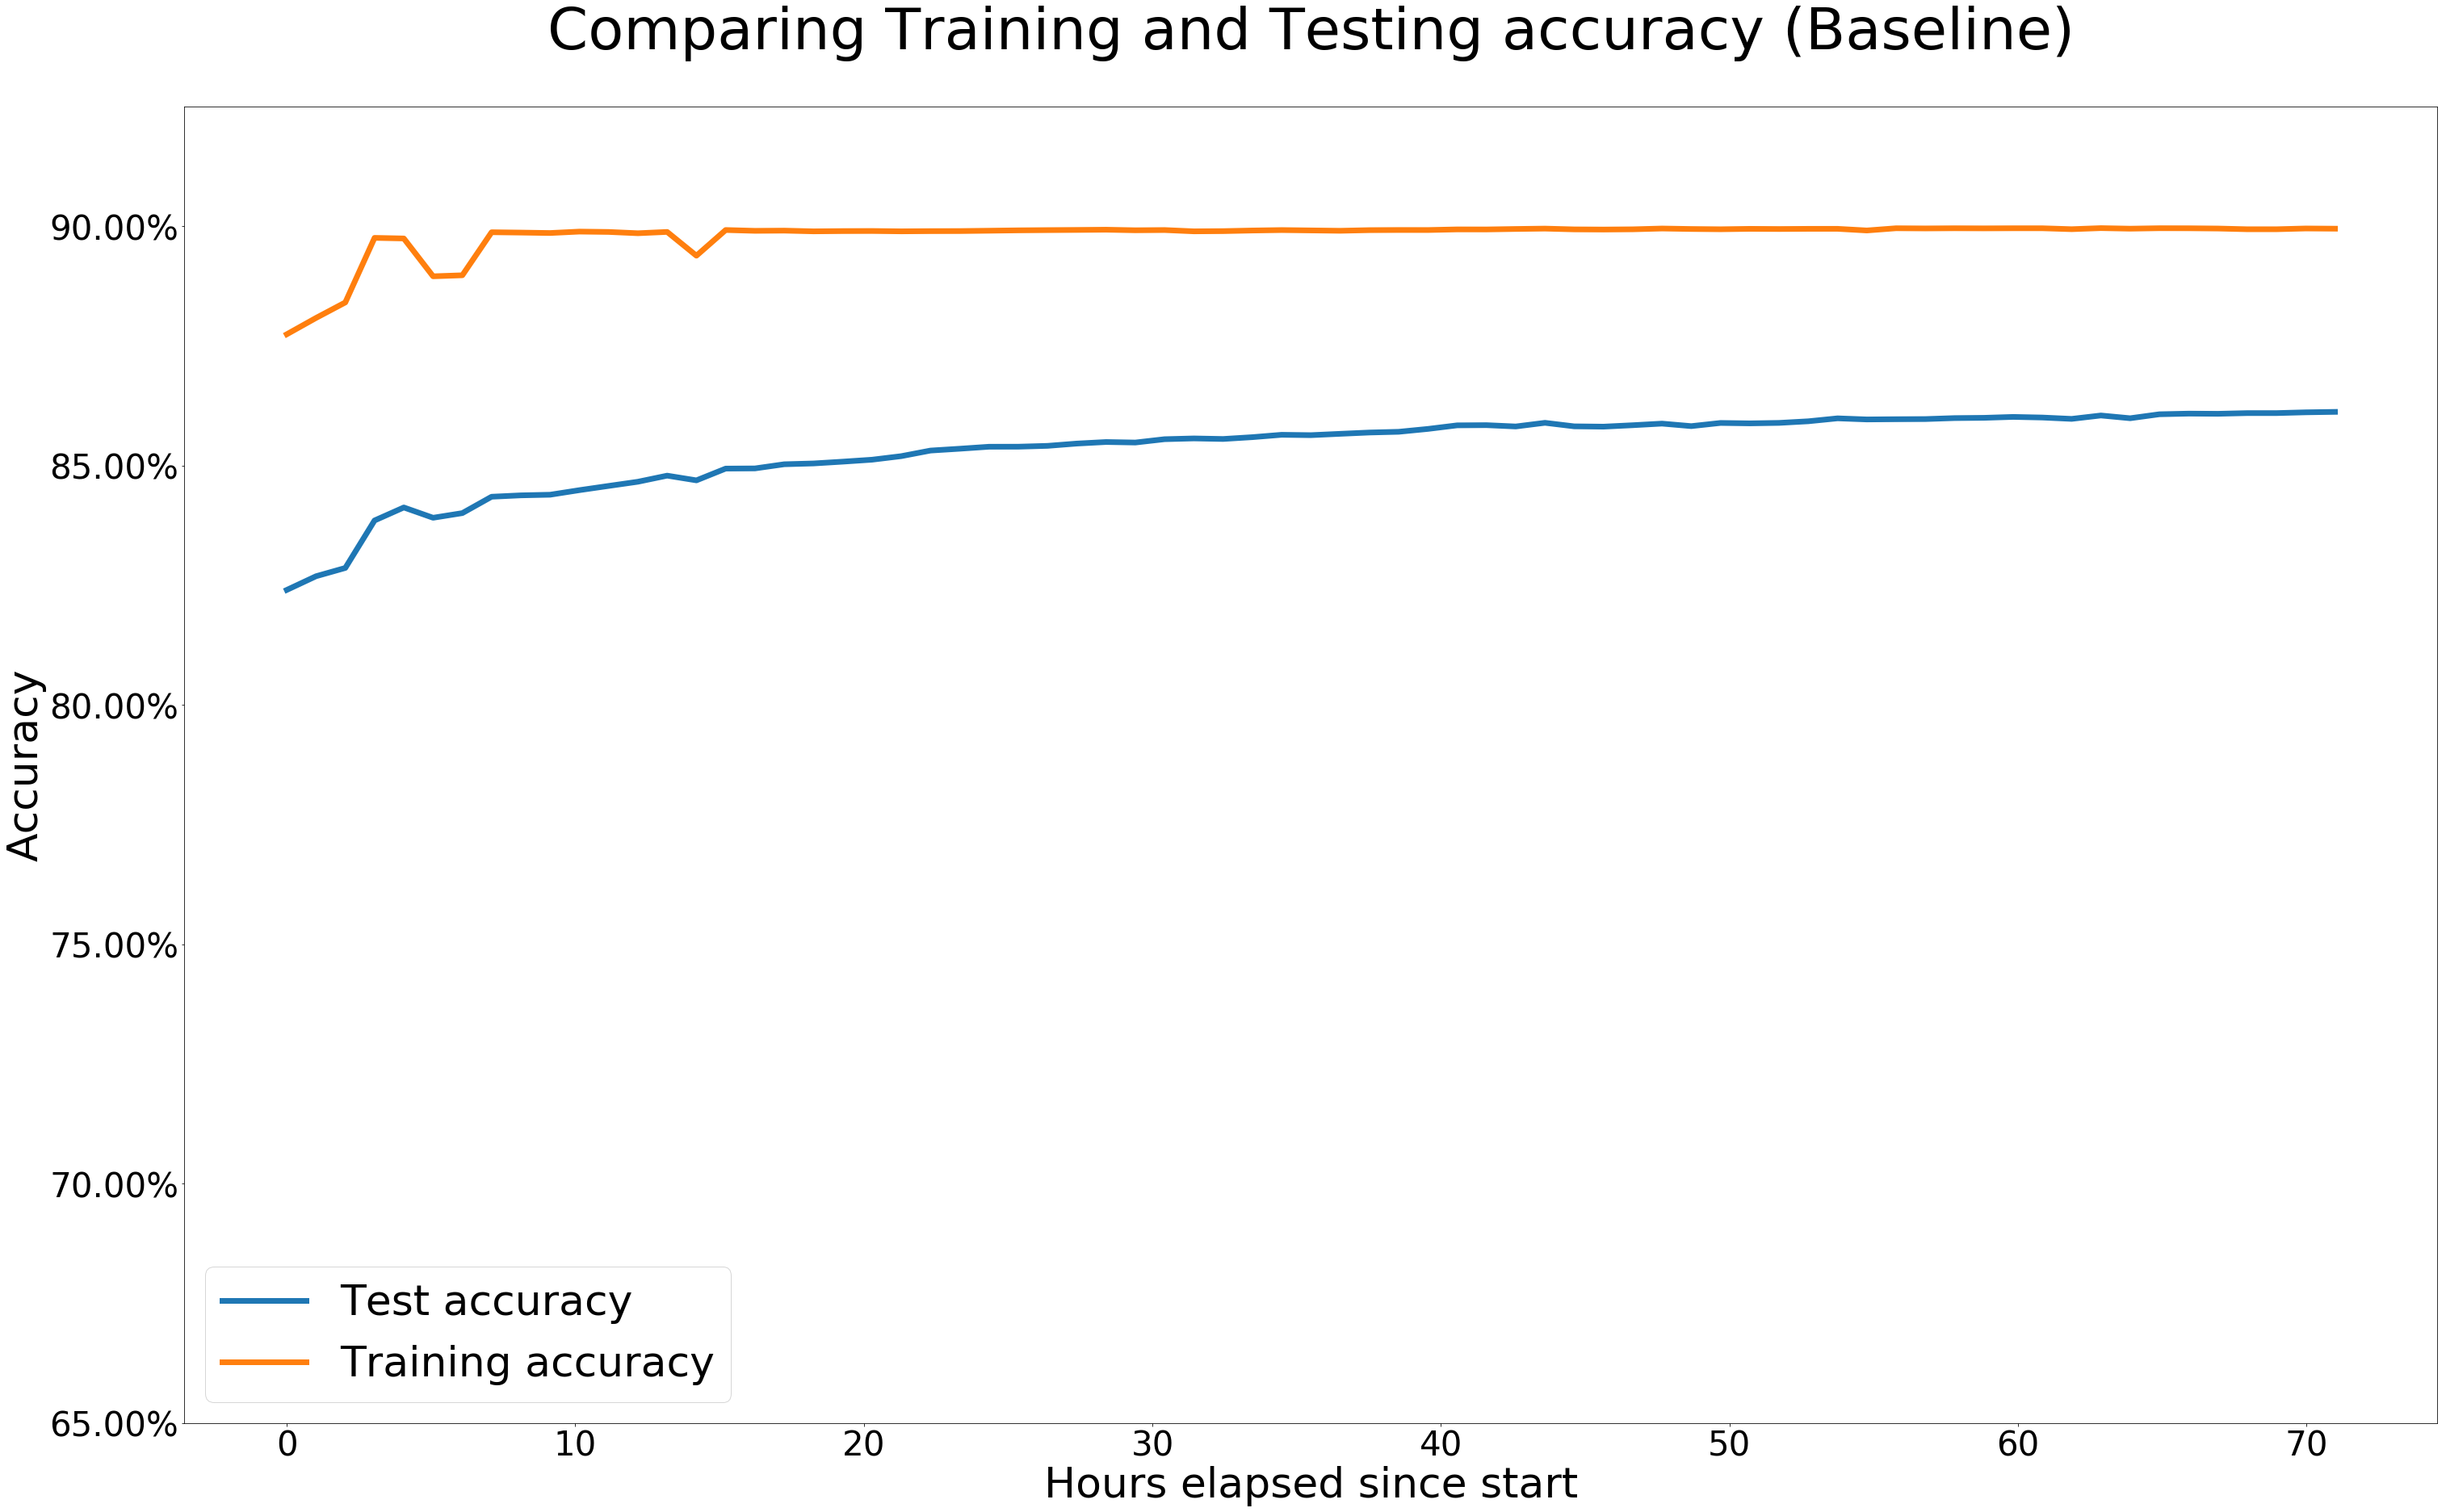

In [11]:
def plot_overfitting(exp, title="Comparing Training and Testing accuracy"):
    title = f"{title} ({exp.name})"
    gens = generations_to_hours(exp)
    plotter(
        x=[
            exp.avg_test_acc,
            exp.avg_acc
        ], 
        y=gens, 
        labels=[
            "Test accuracy",
            "Training accuracy",
        ], 
        title=title,
        percent=True,
        xaxis_title="Hours elapsed since start",
        yaxis_title="Accuracy",
        ylim=(0.0, 1.1)
    )
plot_overfitting(exp01)

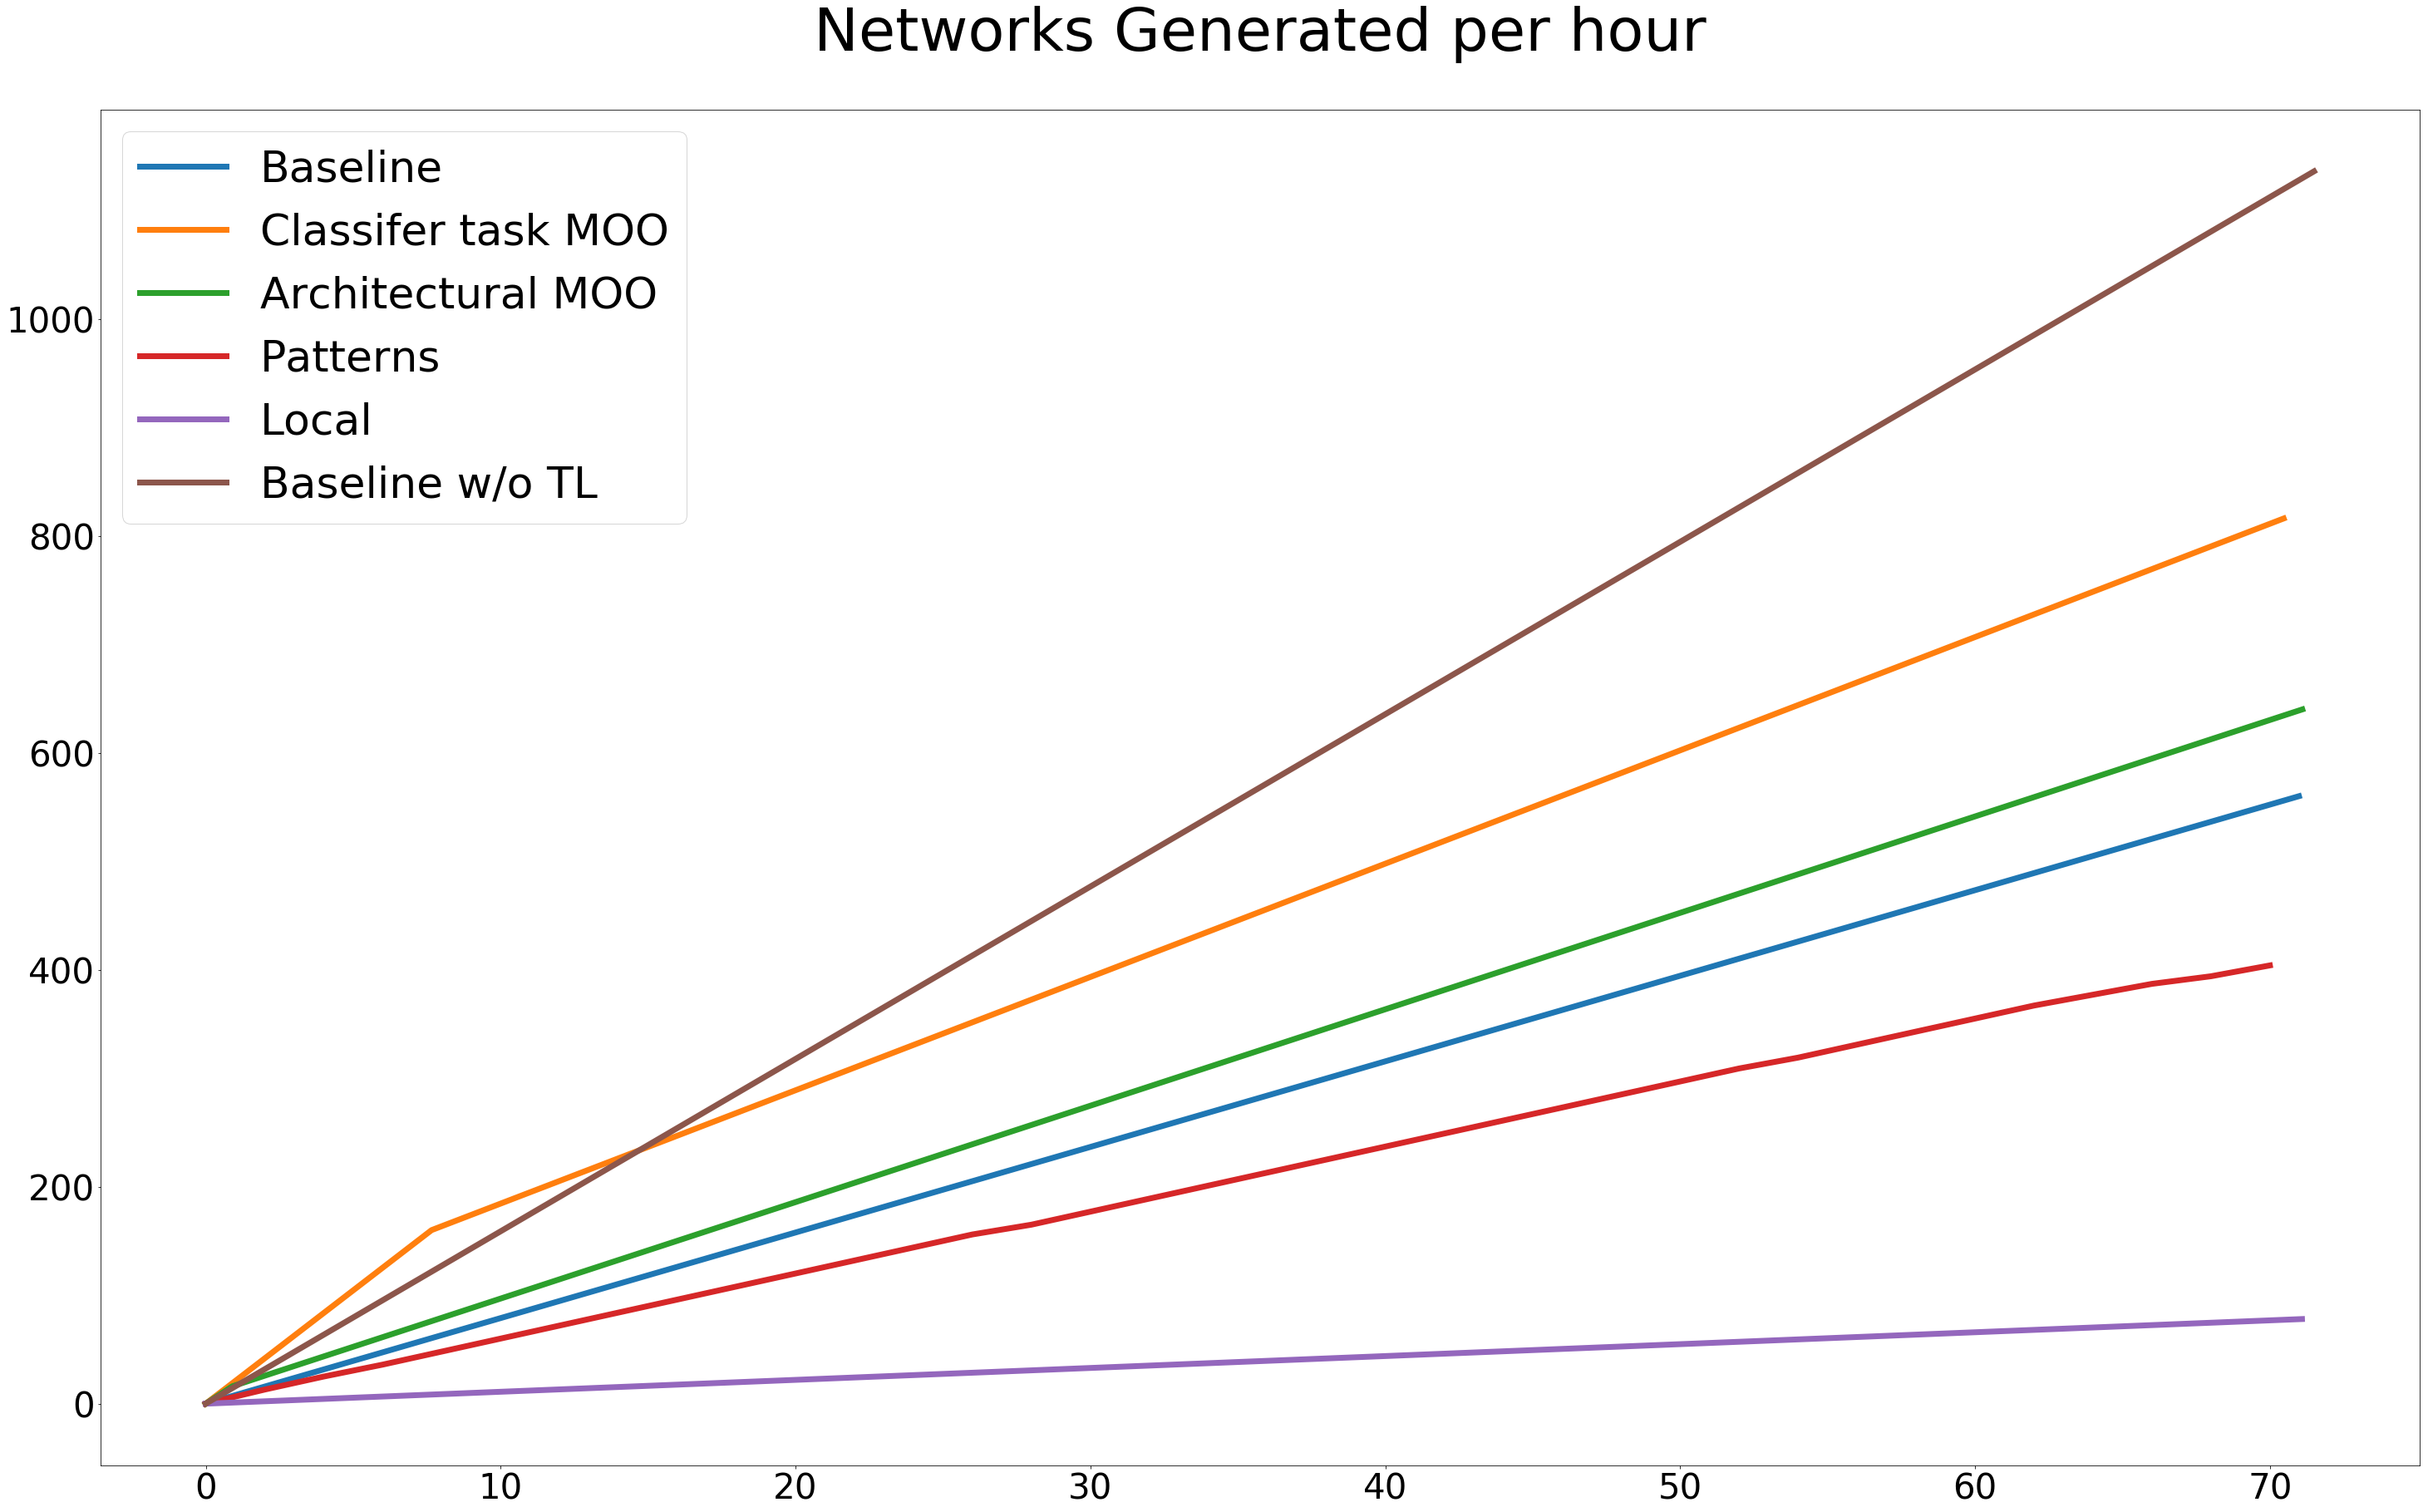

In [12]:
def generations_reached_in_hours(experiments, hours=72):
    fig, axs = plt.subplots(nrows=len(experiments), sharex=True)
    max_inds_seen = max([
        sum([len(gen) for gen in exp.generations]) for exp in experiments
    ])
    for ax, exp in zip(axs, experiments):
        ax.set_title(exp.name, fontsize=46)
        x = [sum([len(gen) for gen in exp.generations[:i]]) for i in range(len(exp.generations))]
        ax.bar(
            generations_to_hours(exp),
            x,
            
        )
        ax.set_yticks(list(range(0, max_inds_seen, 200)))
    fig.suptitle("Networks Generated per hour", fontsize=64)


def generations_reached_in_hours2(experiments, hours=72):
    fig, ax = plt.subplots(111)
    max_inds_seen = max([
        sum([len(gen) for gen in exp.generations]) for exp in experiments
    ])
    x = []
    y = []
    labels = []
    for exp in experiments:
        #ax.set_title(exp.name, fontsize=46)
        x += [[sum([len(gen) for gen in exp.generations[:i]]) for i in range(len(exp.generations))]]
        y += [generations_to_hours(exp)]
        labels += [exp.name]
        
    plotter(x=x, y=y, title="Networks Generated per hour", labels=labels)

generations_reached_in_hours2(experiments)

### Looking at types of nodes within the population for each generation

In [13]:
from src.buildingblocks.ops import pooling, dense, convolution

def best_individ_in_generation(generation):
    best = None
    for ind in generation:
        if not best:
            best = ind
            continue

        if best.test_acc() < ind.test_acc():
            best = ind
    return best

def plot_nodetypes(exp, title):
    gens = list(range(len(exp.generations)))
    p, c, d, t = [], [], [], []
    p_b, c_b, d_b, t_b = [], [], [], []
    for gen in exp.generations:
        p += [len([x for ind in gen for x in ind.children if isinstance(x, pooling.Pooling)]) / len(gen)]
        d += [len([x for ind in gen for x in ind.children if isinstance(x, dense.Dense)]) / len(gen)]
        c += [len([x for ind in gen for x in ind.children if isinstance(x, convolution.Conv2D)]) / len(gen)]
        t += [sum([len(ind.children) for ind in gen]) / len(gen)]
        
        best = best_individ_in_generation(gen)
        p_b += [len([x for x in best.children if isinstance(x, pooling.Pooling)])]
        d_b += [len([x for x in best.children if isinstance(x, dense.Dense)])]
        c_b += [len([x for x in best.children if isinstance(x, convolution.Conv2D)])]
        t_b += [len(best.children)]
        
    labels=[
        "Pooling Layers", "Conv2D Layers", "Dense Layers", "Total Layers",
        #"Top Pooling Layers", "Top Conv2D Layers", "Top Dense Layers", "Top Total Layers" 
    ]
    title += f" ({exp.name})"
    plotter(
        x=[p, c, d, t], 
        y=generations_to_hours(exp), 
        labels=labels, 
        title=title, 
        ylim=(0, 25), 
        xaxis_title="Hours elapsed since start", 
        yaxis_title="Average # nodes in genotype"
    )

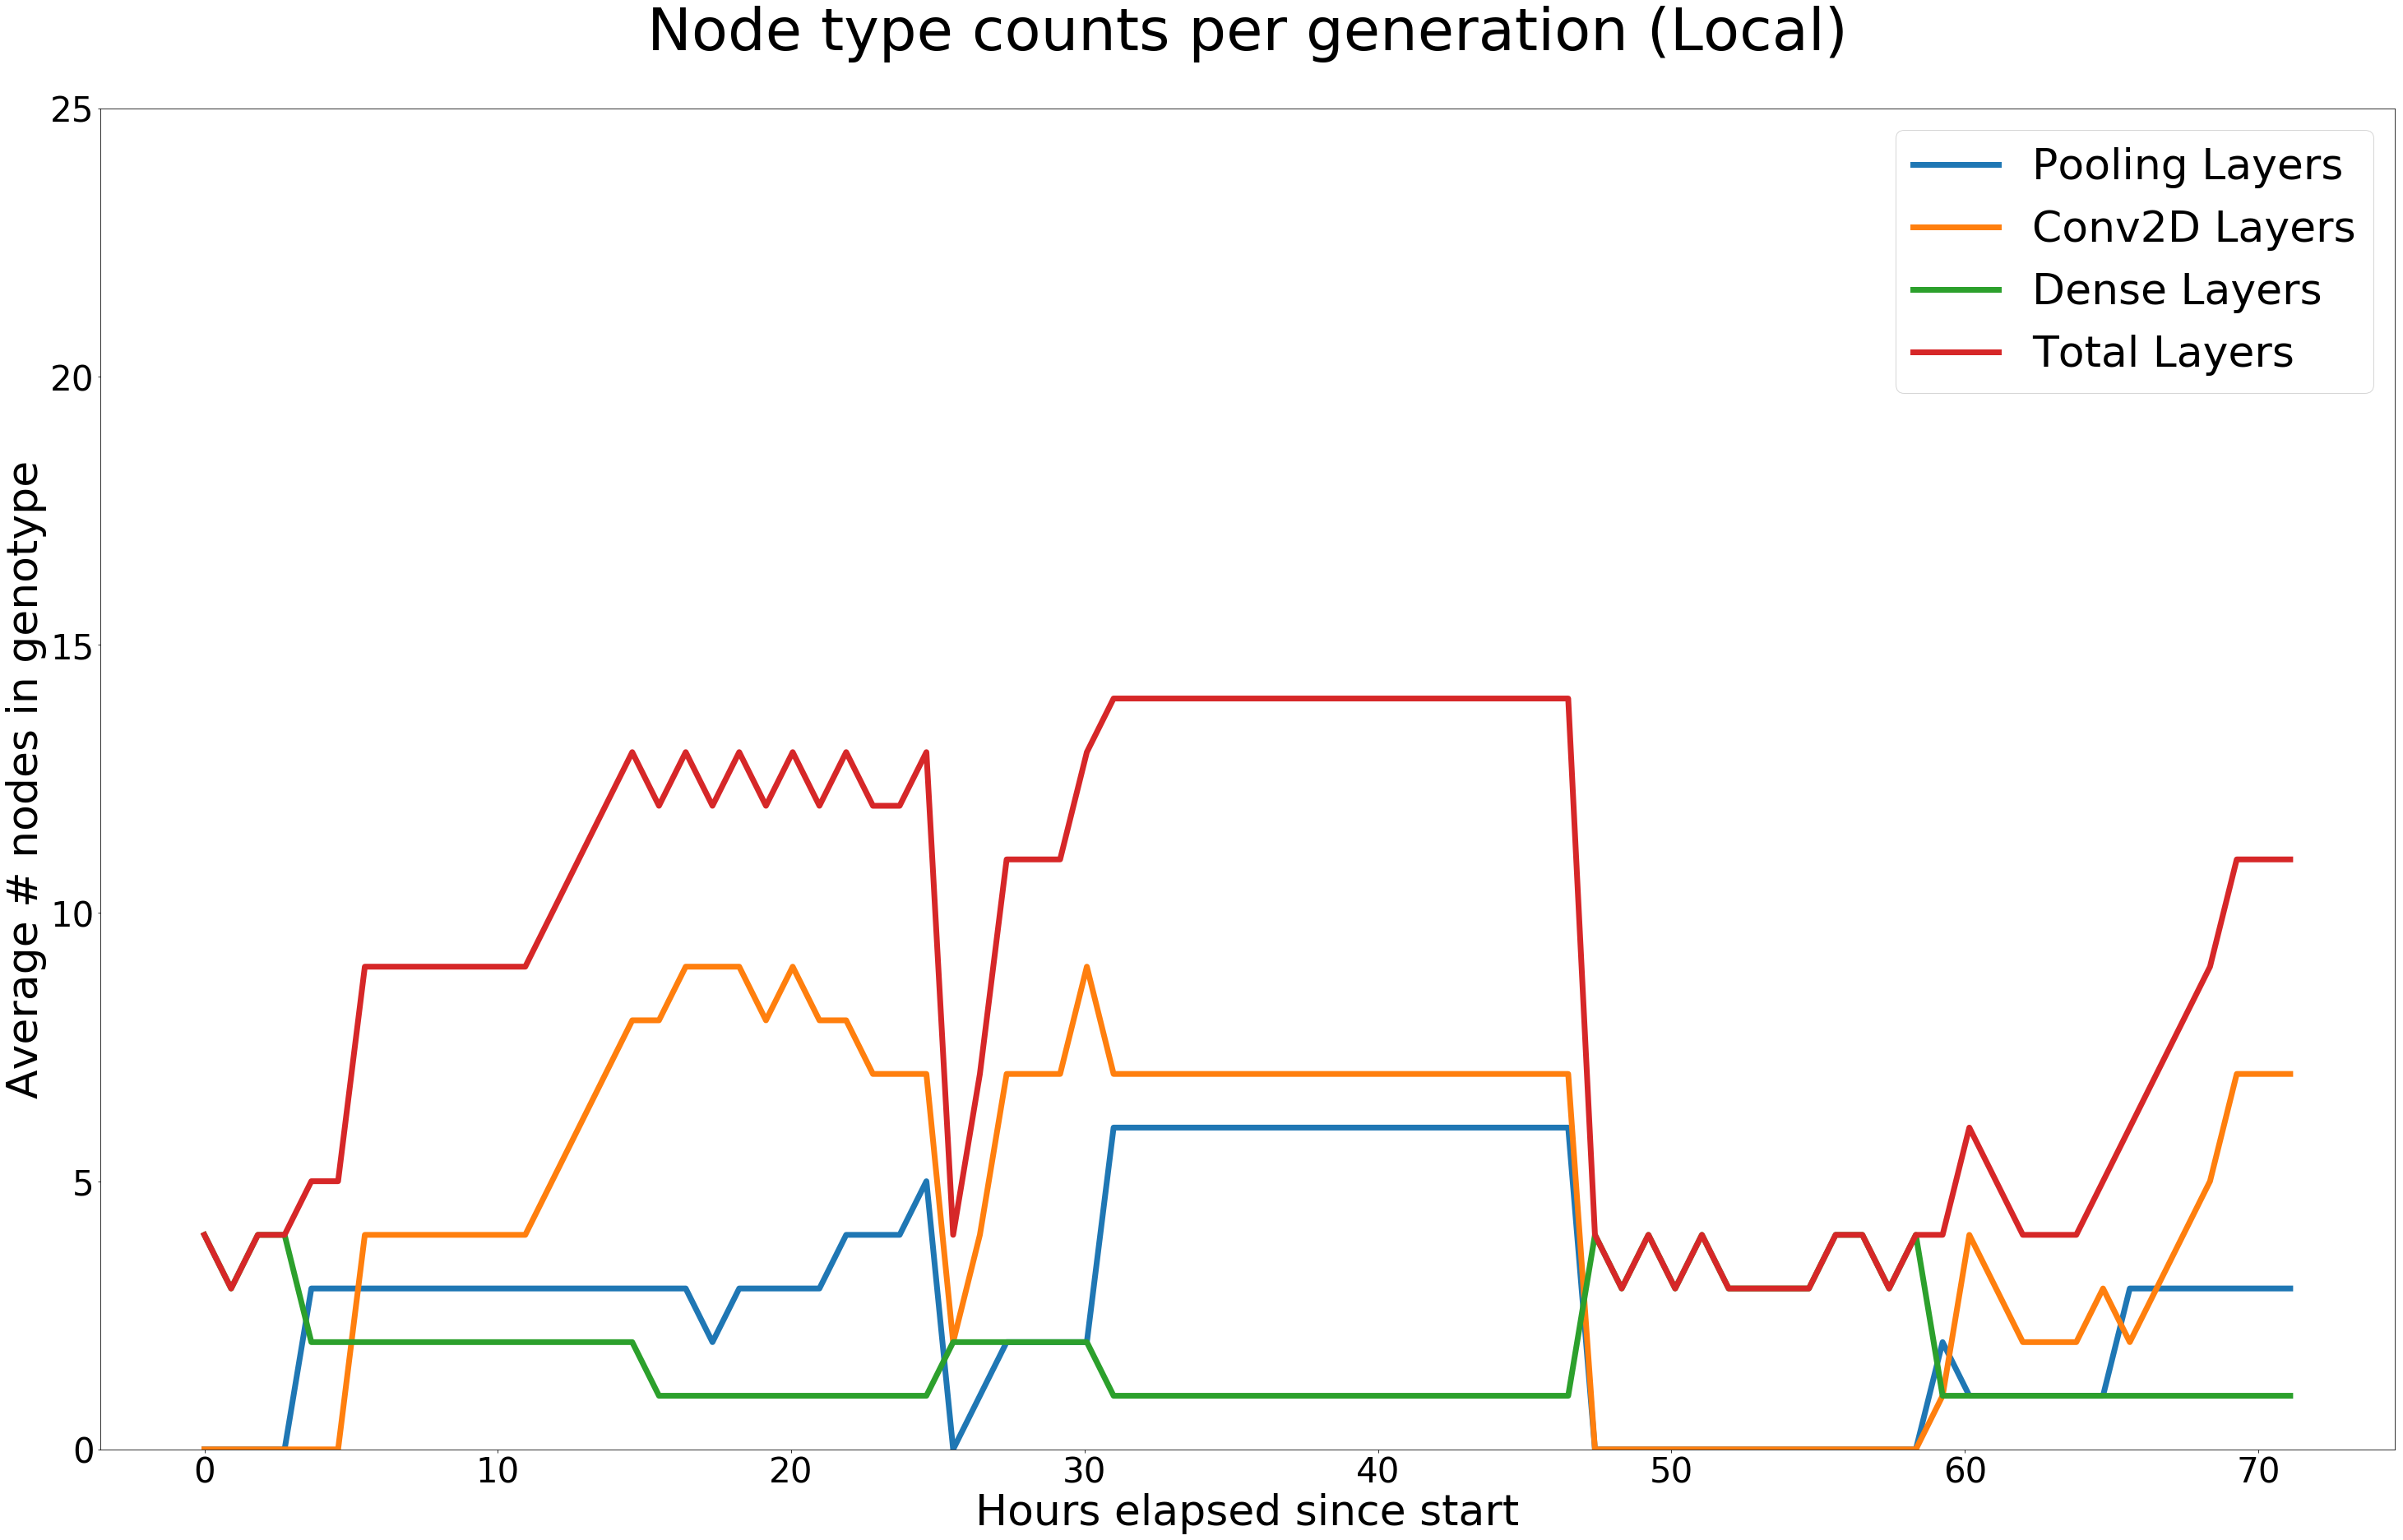

In [14]:
plot_nodetypes(exp05, "Node type counts per generation")

In [15]:
def layer_distribution(experiments, title="Node type distribution over time"):
    title += f" ({', '.join([exp.name for exp in experiments])})"
    fig, (ax_conv, ax_pool, ax_dense) = plt.subplots(nrows=3, sharex=True)
    for exp in experiments:
        hours = generations_to_hours(exp)
        gen_pool, gen_conv, gen_dense = [], [], []
        for gen in exp.generations:
            p, d, c = [],[],[]    
            for ind in gen:            
                p += [len([x for x in ind.children if isinstance(x, pooling.Pooling)]) / len(ind.children)]
                d += [len([x for x in ind.children if isinstance(x, dense.Dense)]) / len(ind.children)]
                c += [len([x for x in ind.children if isinstance(x, convolution.Conv2D)]) / len(ind.children)]
            gen_pool += [sum(p) / len(p)]
            gen_conv += [sum(c) / len(c)]
            gen_dense += [sum(d) / len(d)]
        ax_pool.plot(hours, gen_pool)
        ax_conv.plot(hours, gen_conv)
        ax_dense.plot(hours, gen_dense)
    ax_pool.set_ylim(0, 1.1)    
    ax_conv.set_ylim(0, 1.1)    
    ax_dense.set_ylim(0, 1.1)
    ax_pool.set_title("Average Pooling nodes used per generation", fontsize=50, y=1.02)
    ax_conv.set_title("Average Convolutional nodes used per generation", fontsize=50, y=1.02)
    ax_dense.set_title("Average Dense nodes used per generation", fontsize=50, y=1.02)
    
    fig.suptitle(title, fontsize=72)
    fig.text(0.5, 0.08, 'Hours elapsed since start', ha='center', fontsize=46)
    fig.text(0.08, 0.5, 'Fraction of nodetype in population', va='center', rotation='vertical', fontsize=46)
    plt.savefig(savedir(title))

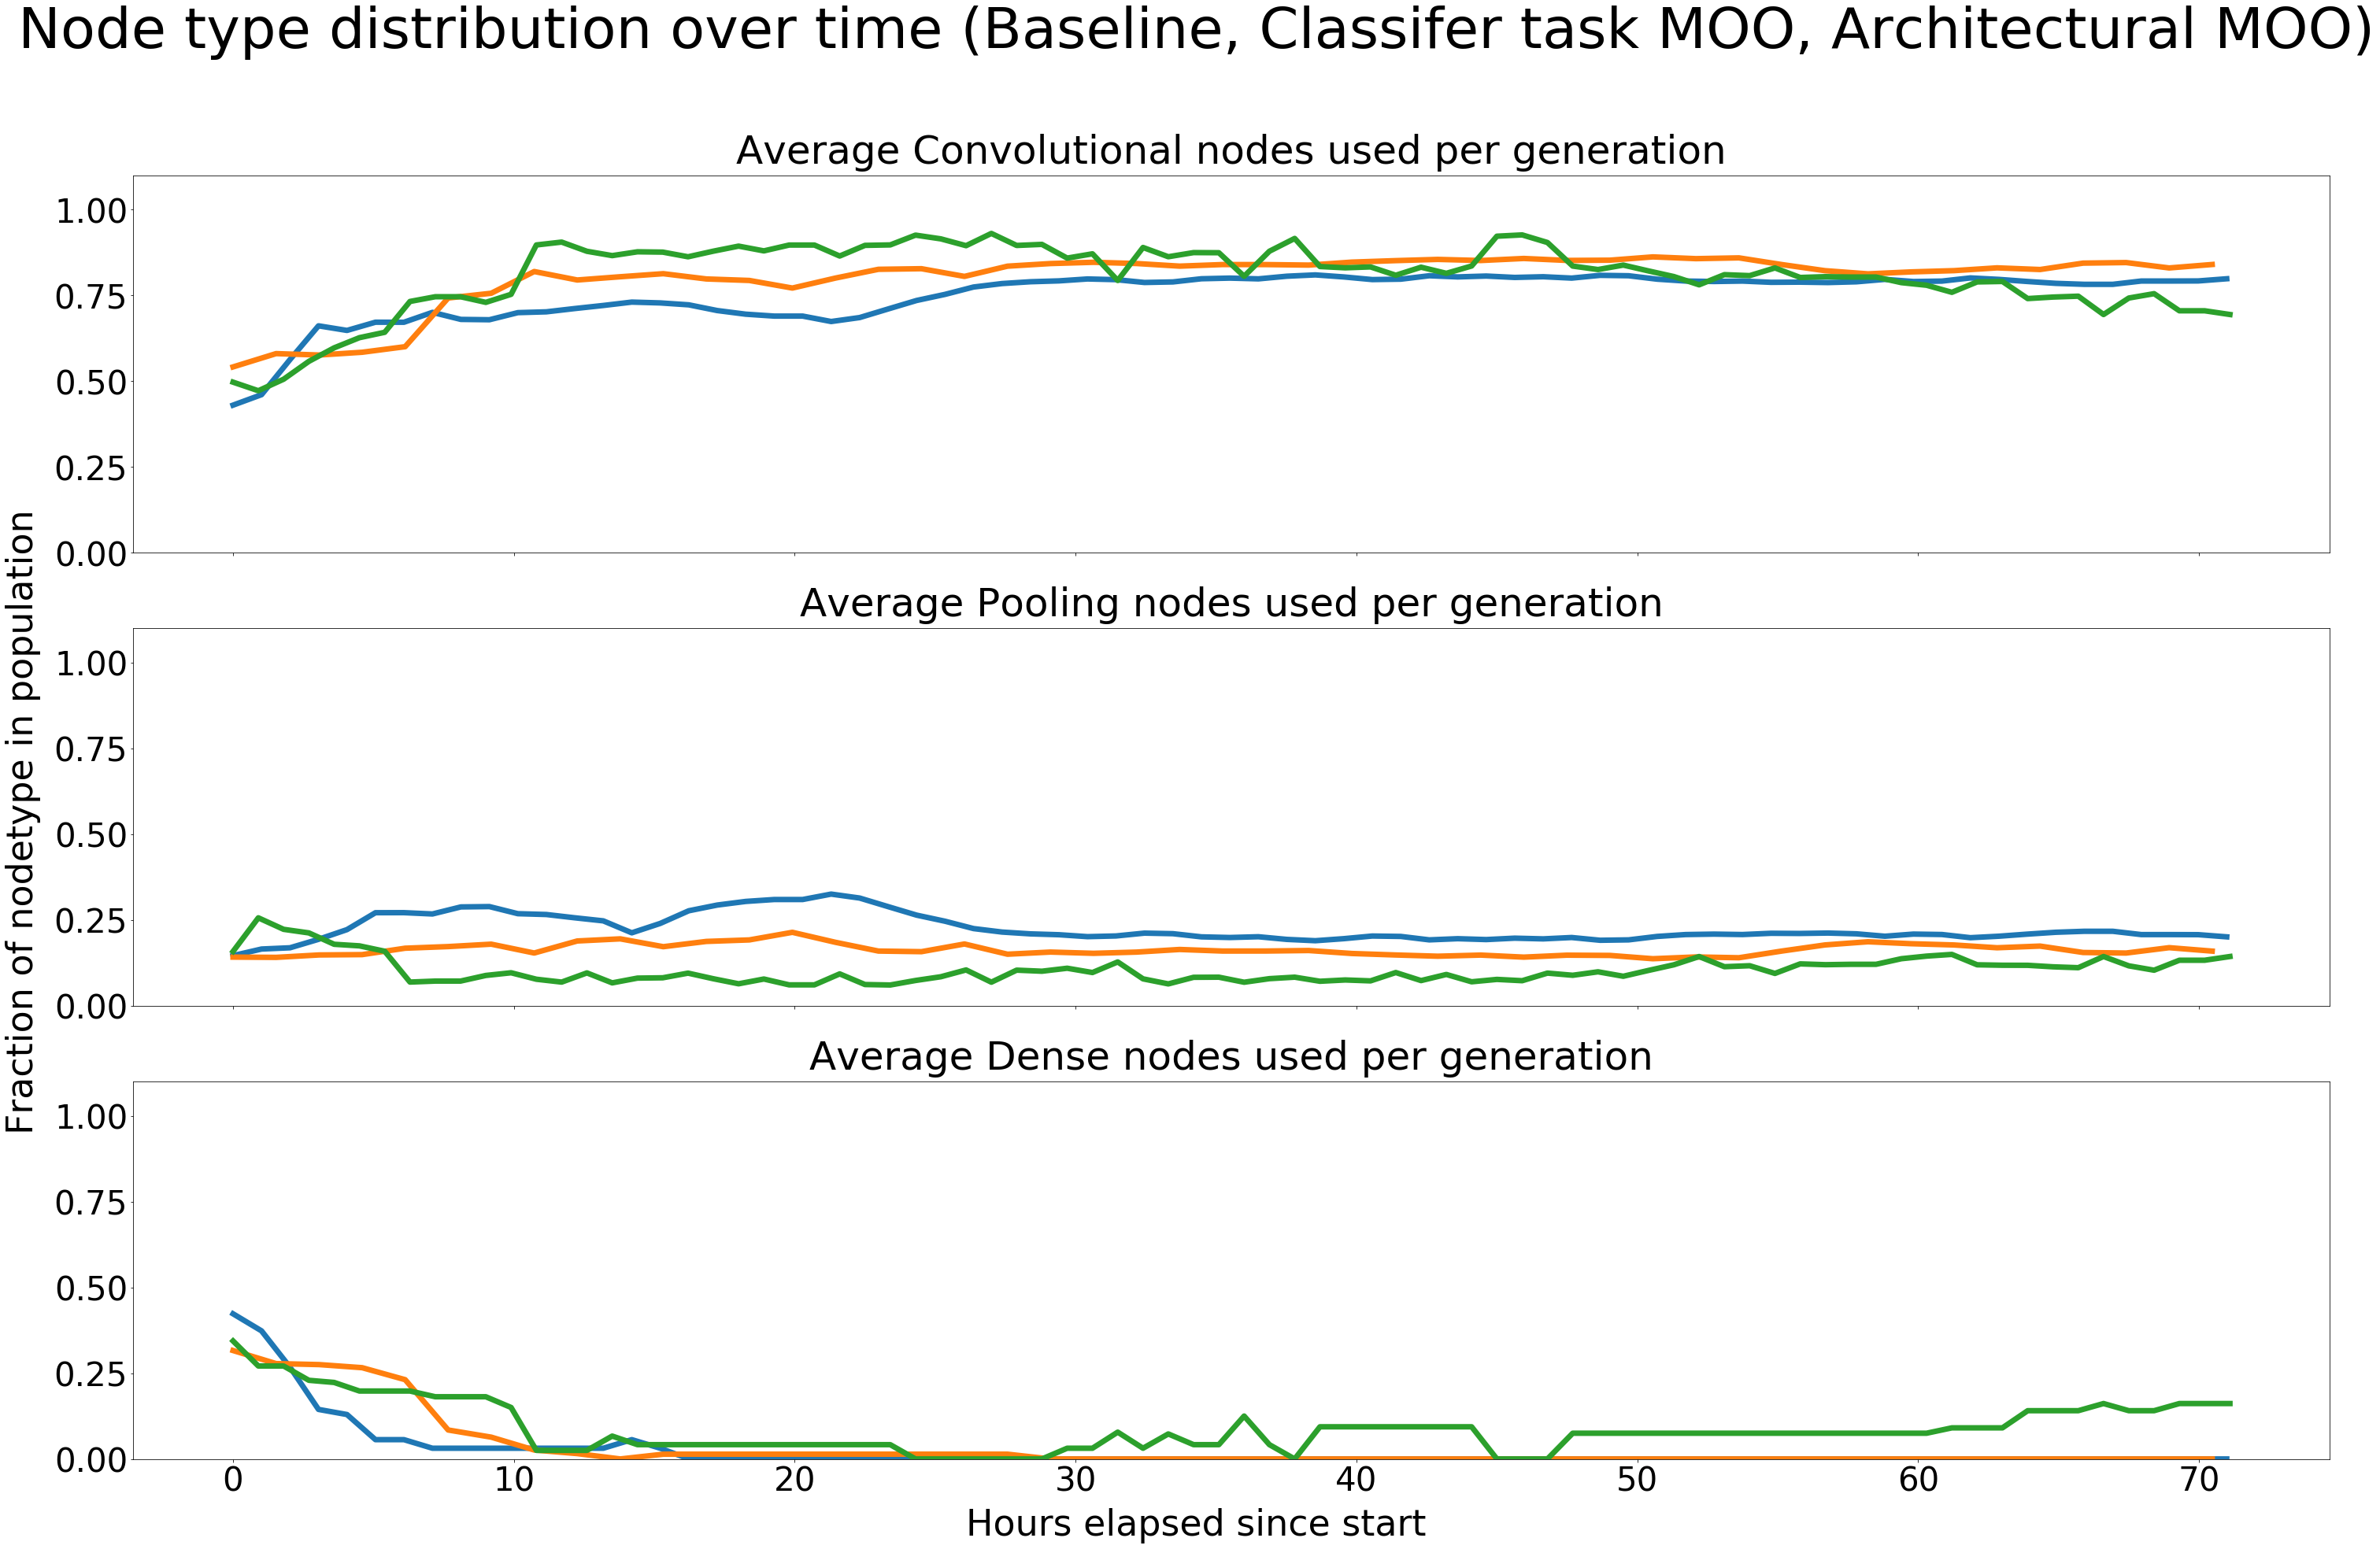

In [16]:
layer_distribution([exp01, exp02, exp03])

Node type distribution used by the evolutionary algorithm over time. Green is Architectural, Orange is Classifer tasks and Blue is Baseline. The hour axis is shared for all meaning that the sum of a particular hour across all three plots is 1 as each hour represents the average.

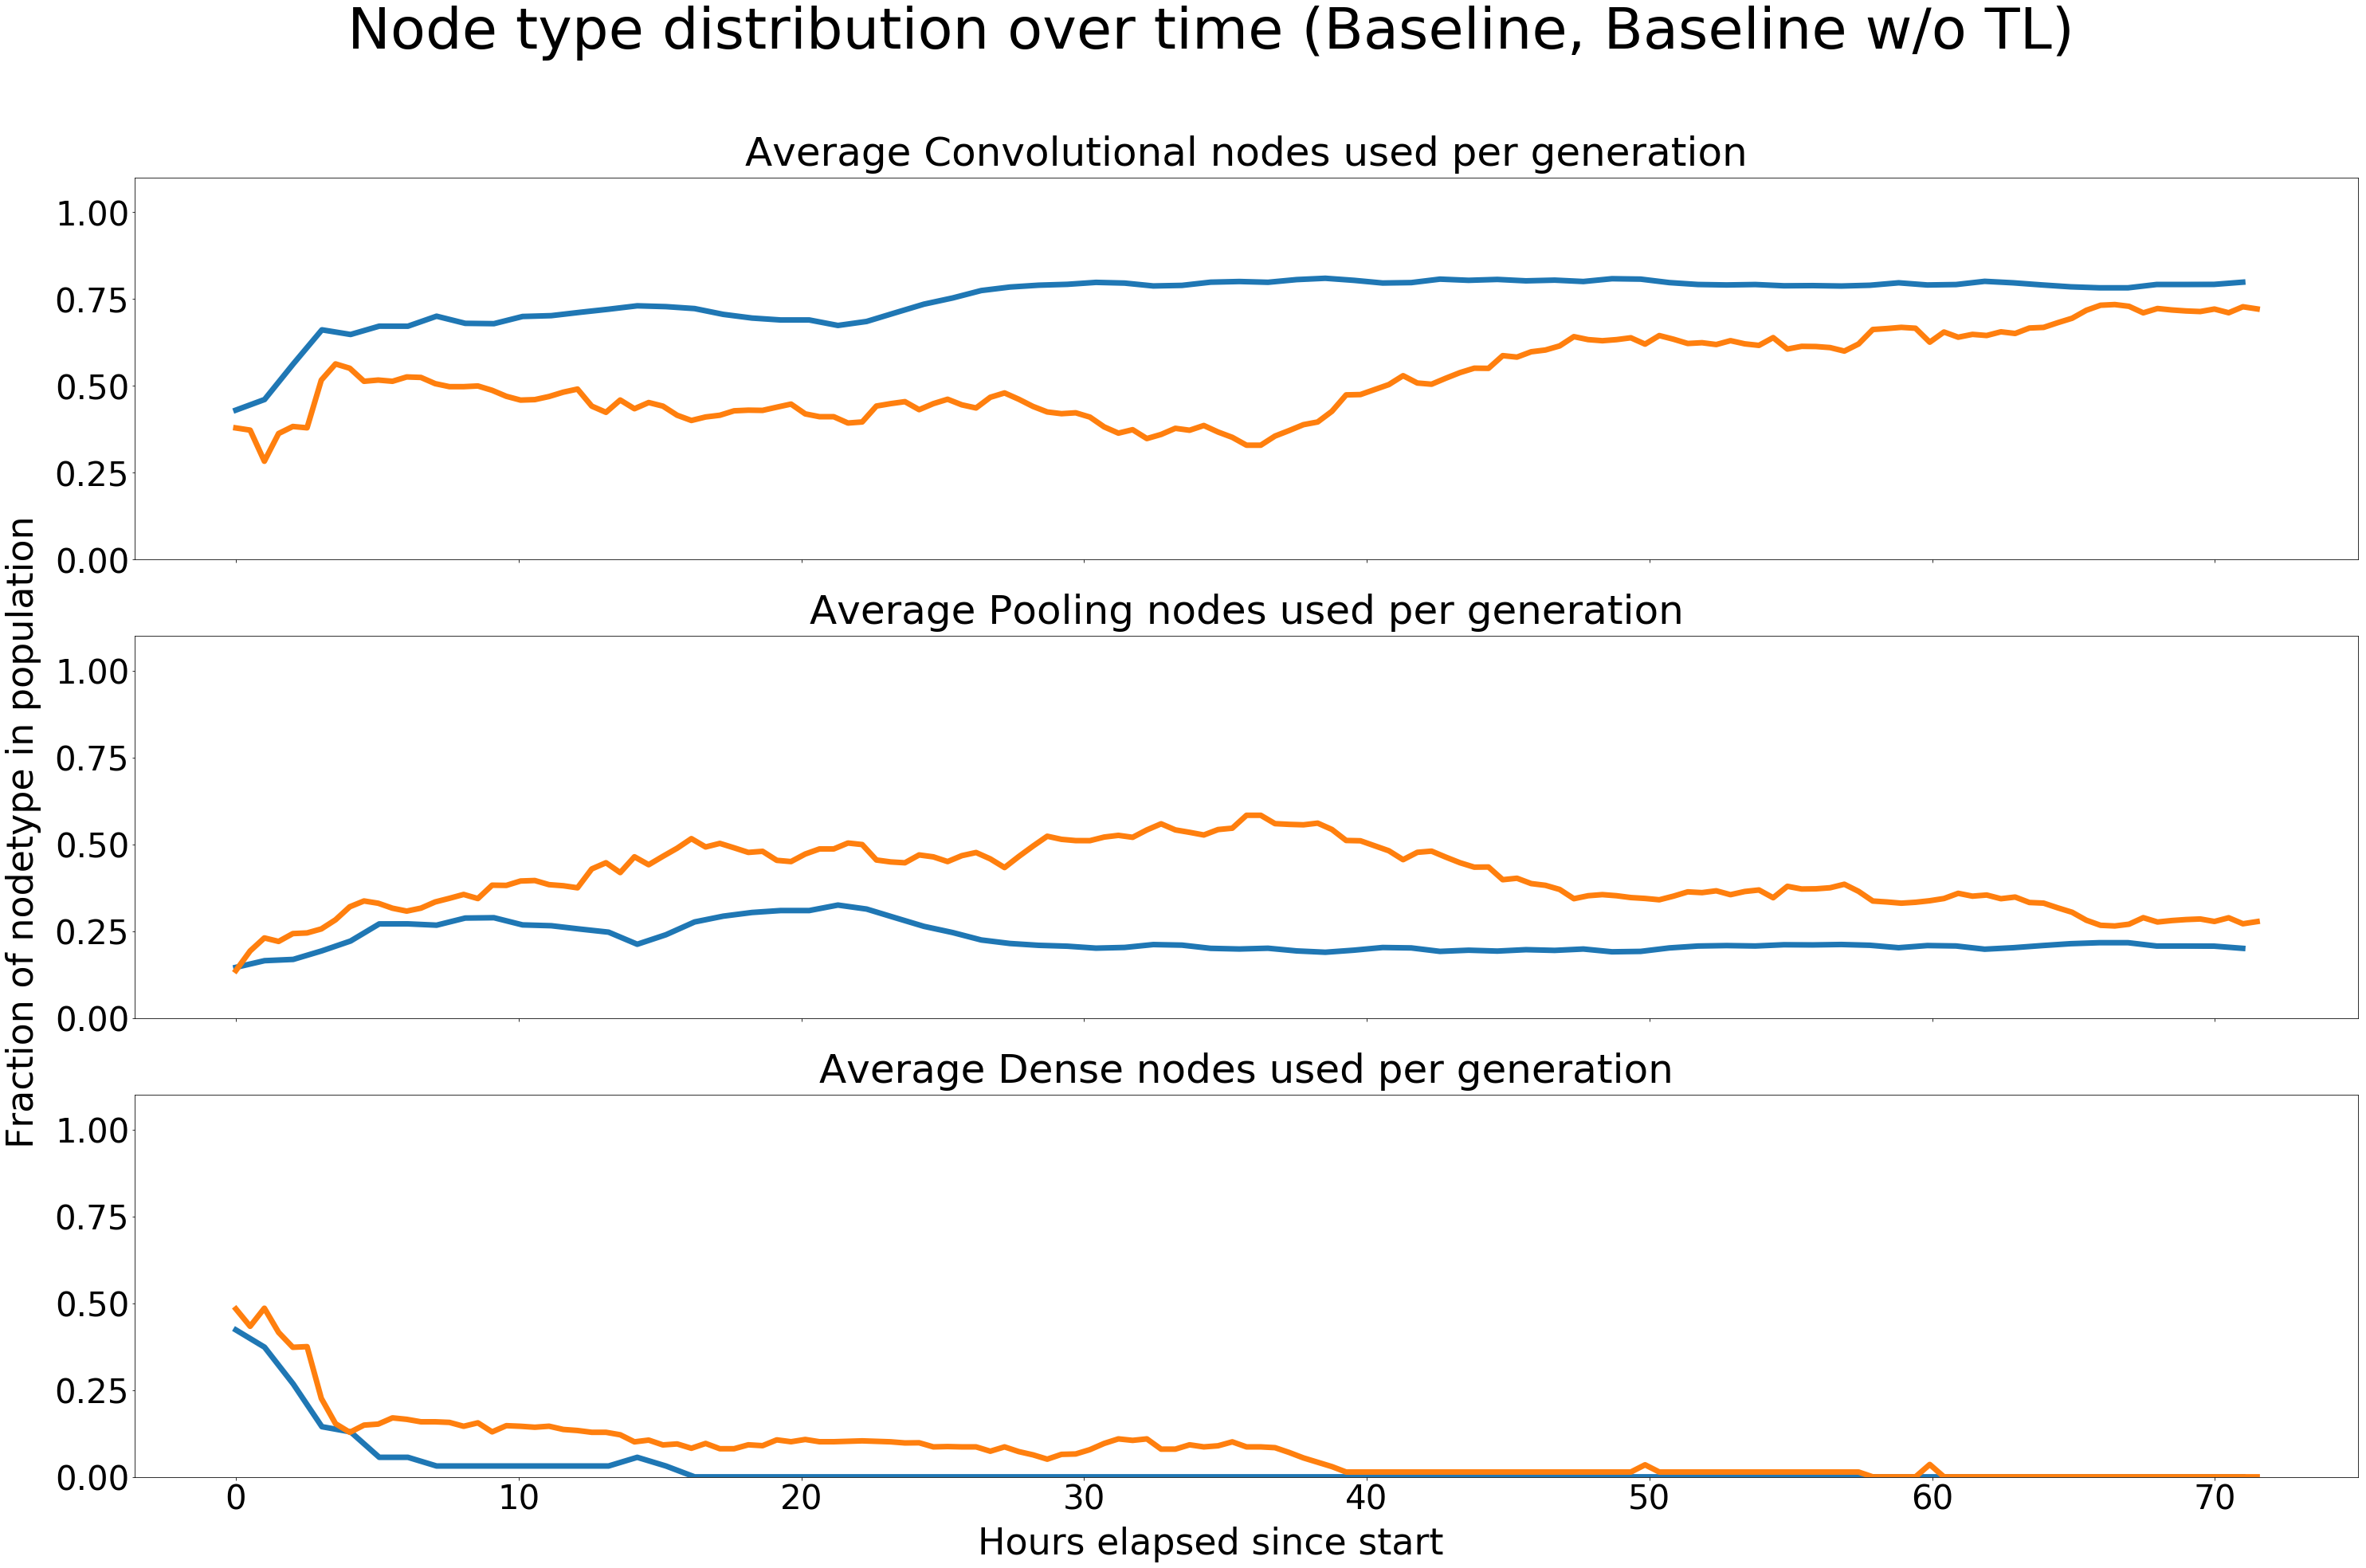

In [31]:
layer_distribution([exp01, exp06])

Here, blue line represents The local experiment while orange lines represent baseline w/o TL.

### Correlation between test accuracy and number of layers?
* Plot within ranges of usage for each layer. 

In [32]:
def plot_correlation_acc_layer_type(exp, acc_type, title):
    gens = list(range(len(exp.generations)))

    types = [("Conv2D", convolution.Conv2D), ("Pooling", pooling.Pooling), ("Dense", dense.Dense)]
    avg_layer_count = {key: [] for key, _ in types}
    for gen in exp.generations:
        for name, layer_type in types:
            avg_layer_count[name] += [
                sum([
                    len([
                        x for x in ind.children if isinstance(x, layer_type)
                    ]) for ind in gen
                ]) / len(gen)
            ]
        
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
    for (name, type), avg in zip(types, avg_layer_count.values()):
        lbl = f"Average {name} layer count"
        ax1.plot(gens, avg, linewidth=7, label=lbl)
    ax2.plot(gens, exp.avg_test_acc, linewidth=7, label="Test set accuracy")
    plot_setup(ax1, "Average layer count")
    plot_setup(ax2, "Average test accuracy")
    plt.savefig(savedir(title))
    plt.show()

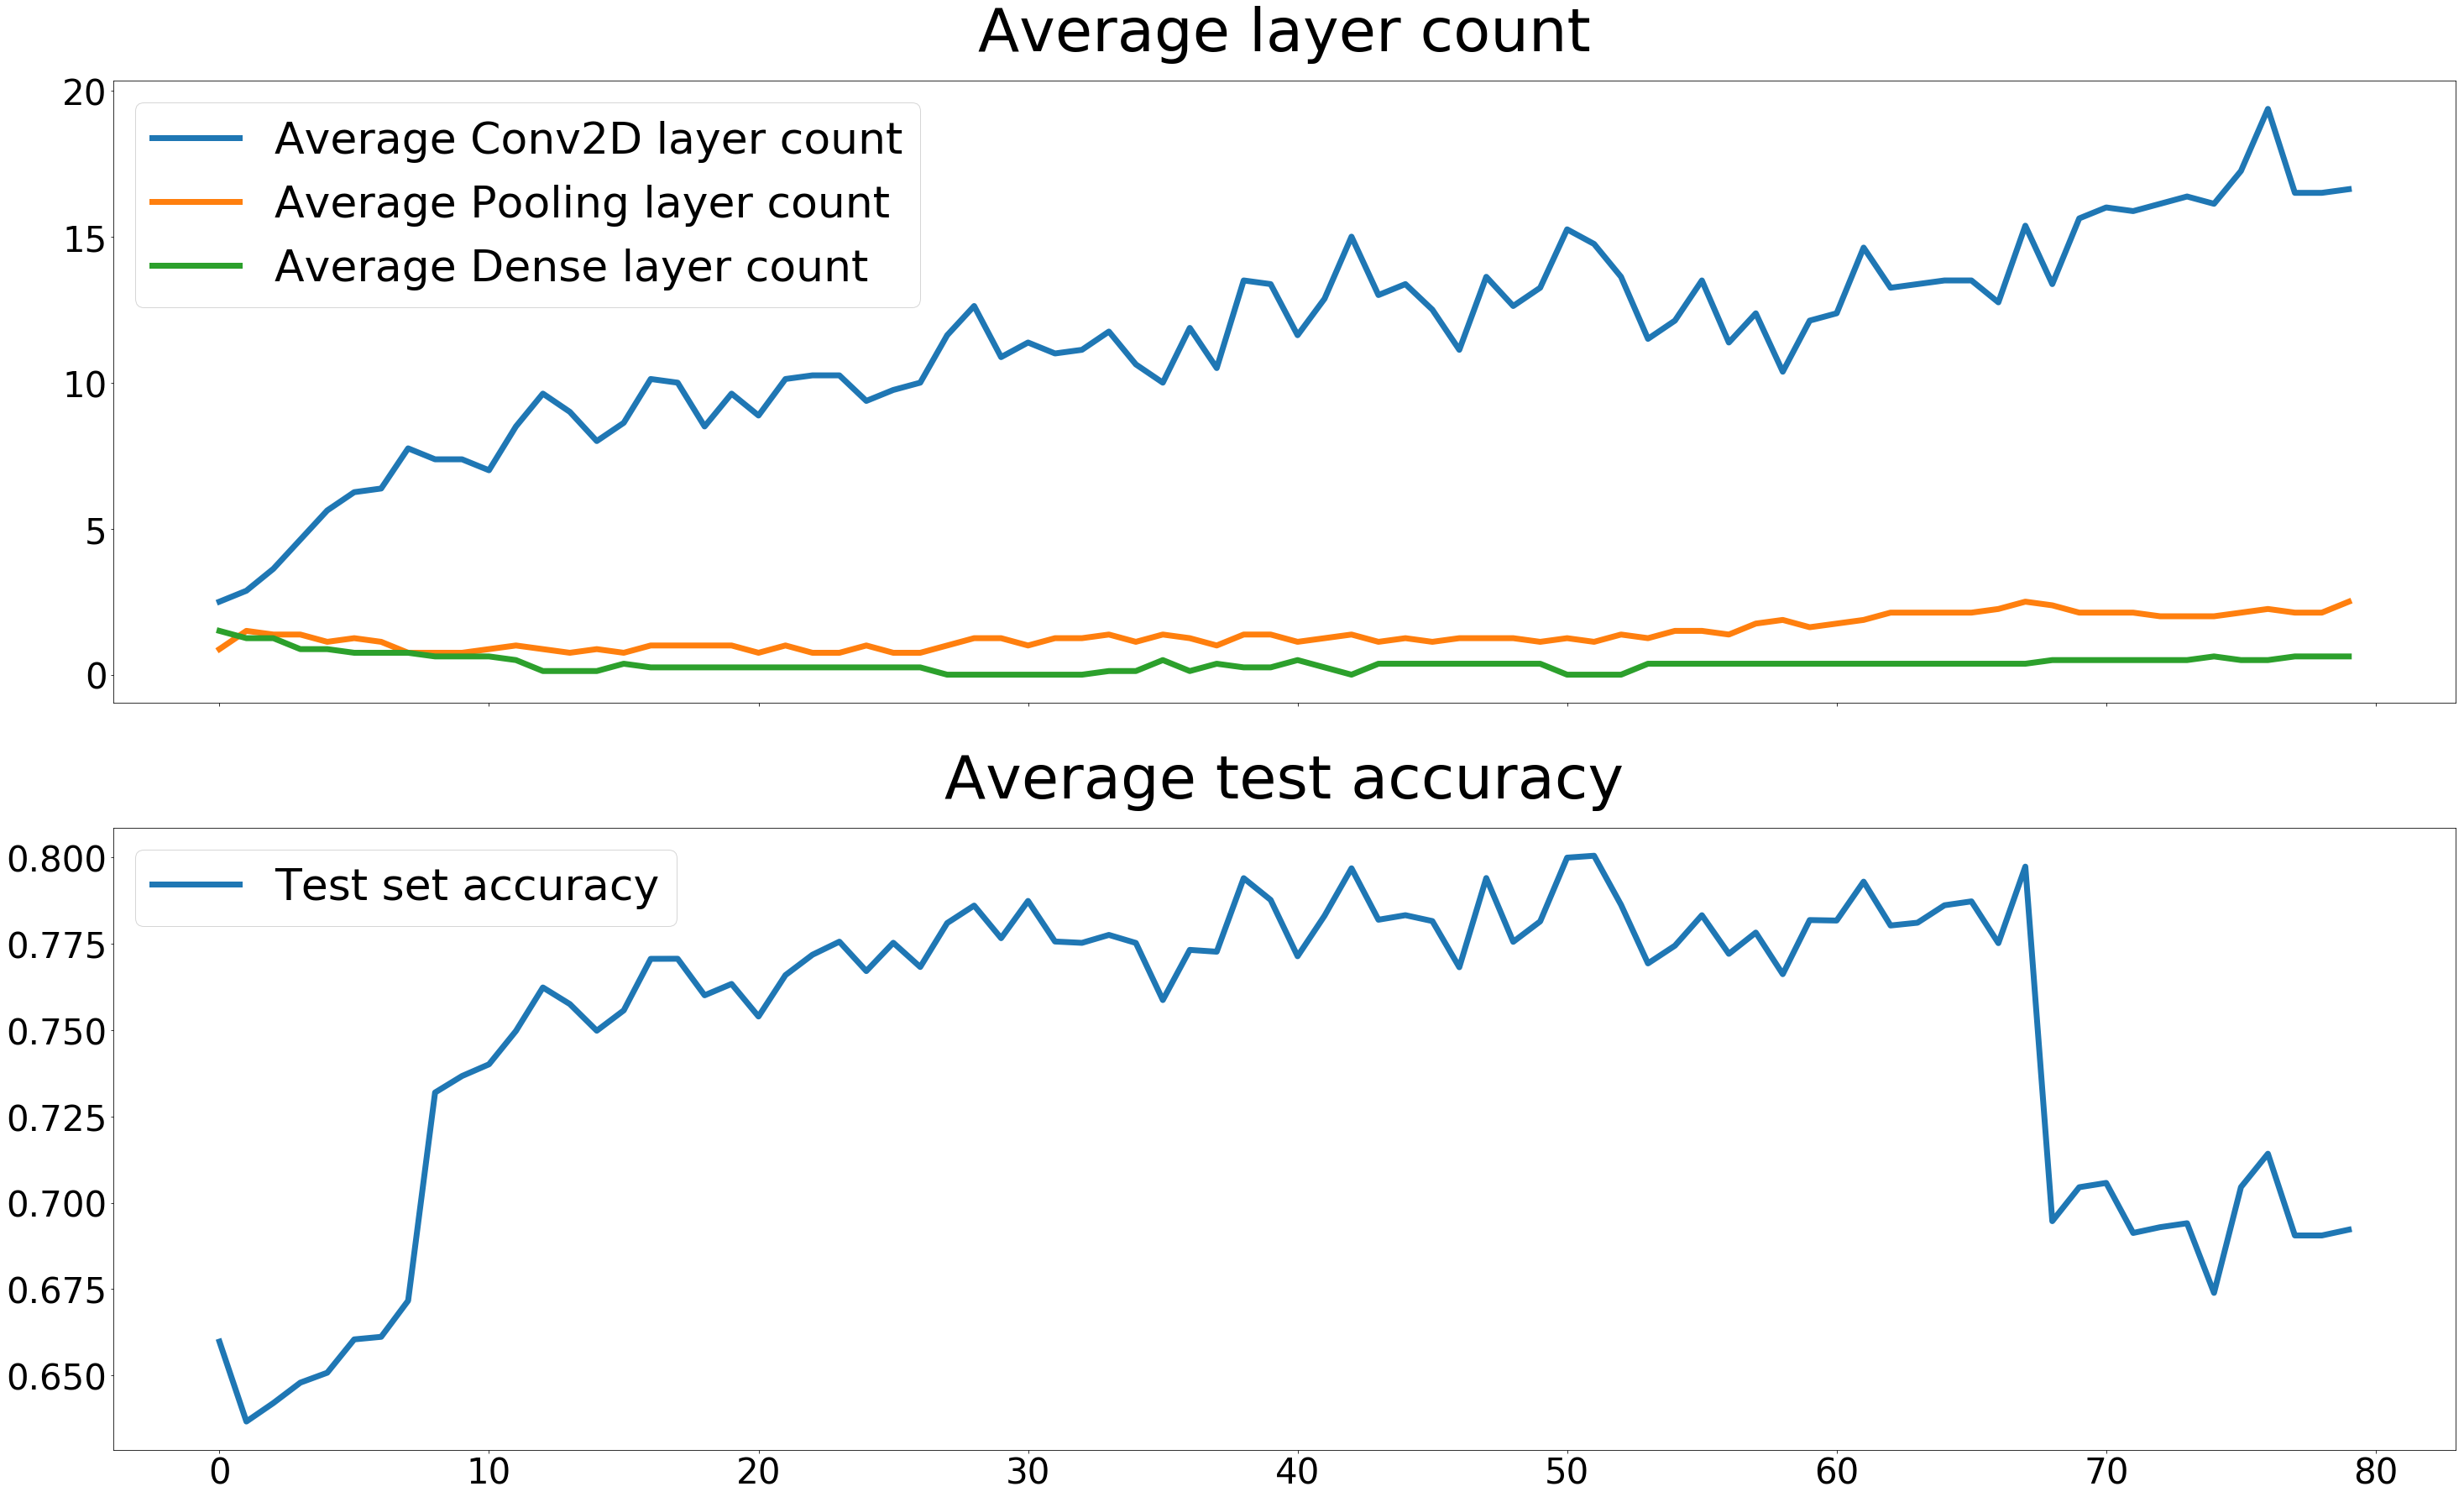

In [33]:
plot_correlation_acc_layer_type(
    exp03, 
    acc_type="test",
    title="Conv2D over Test ACC"
)

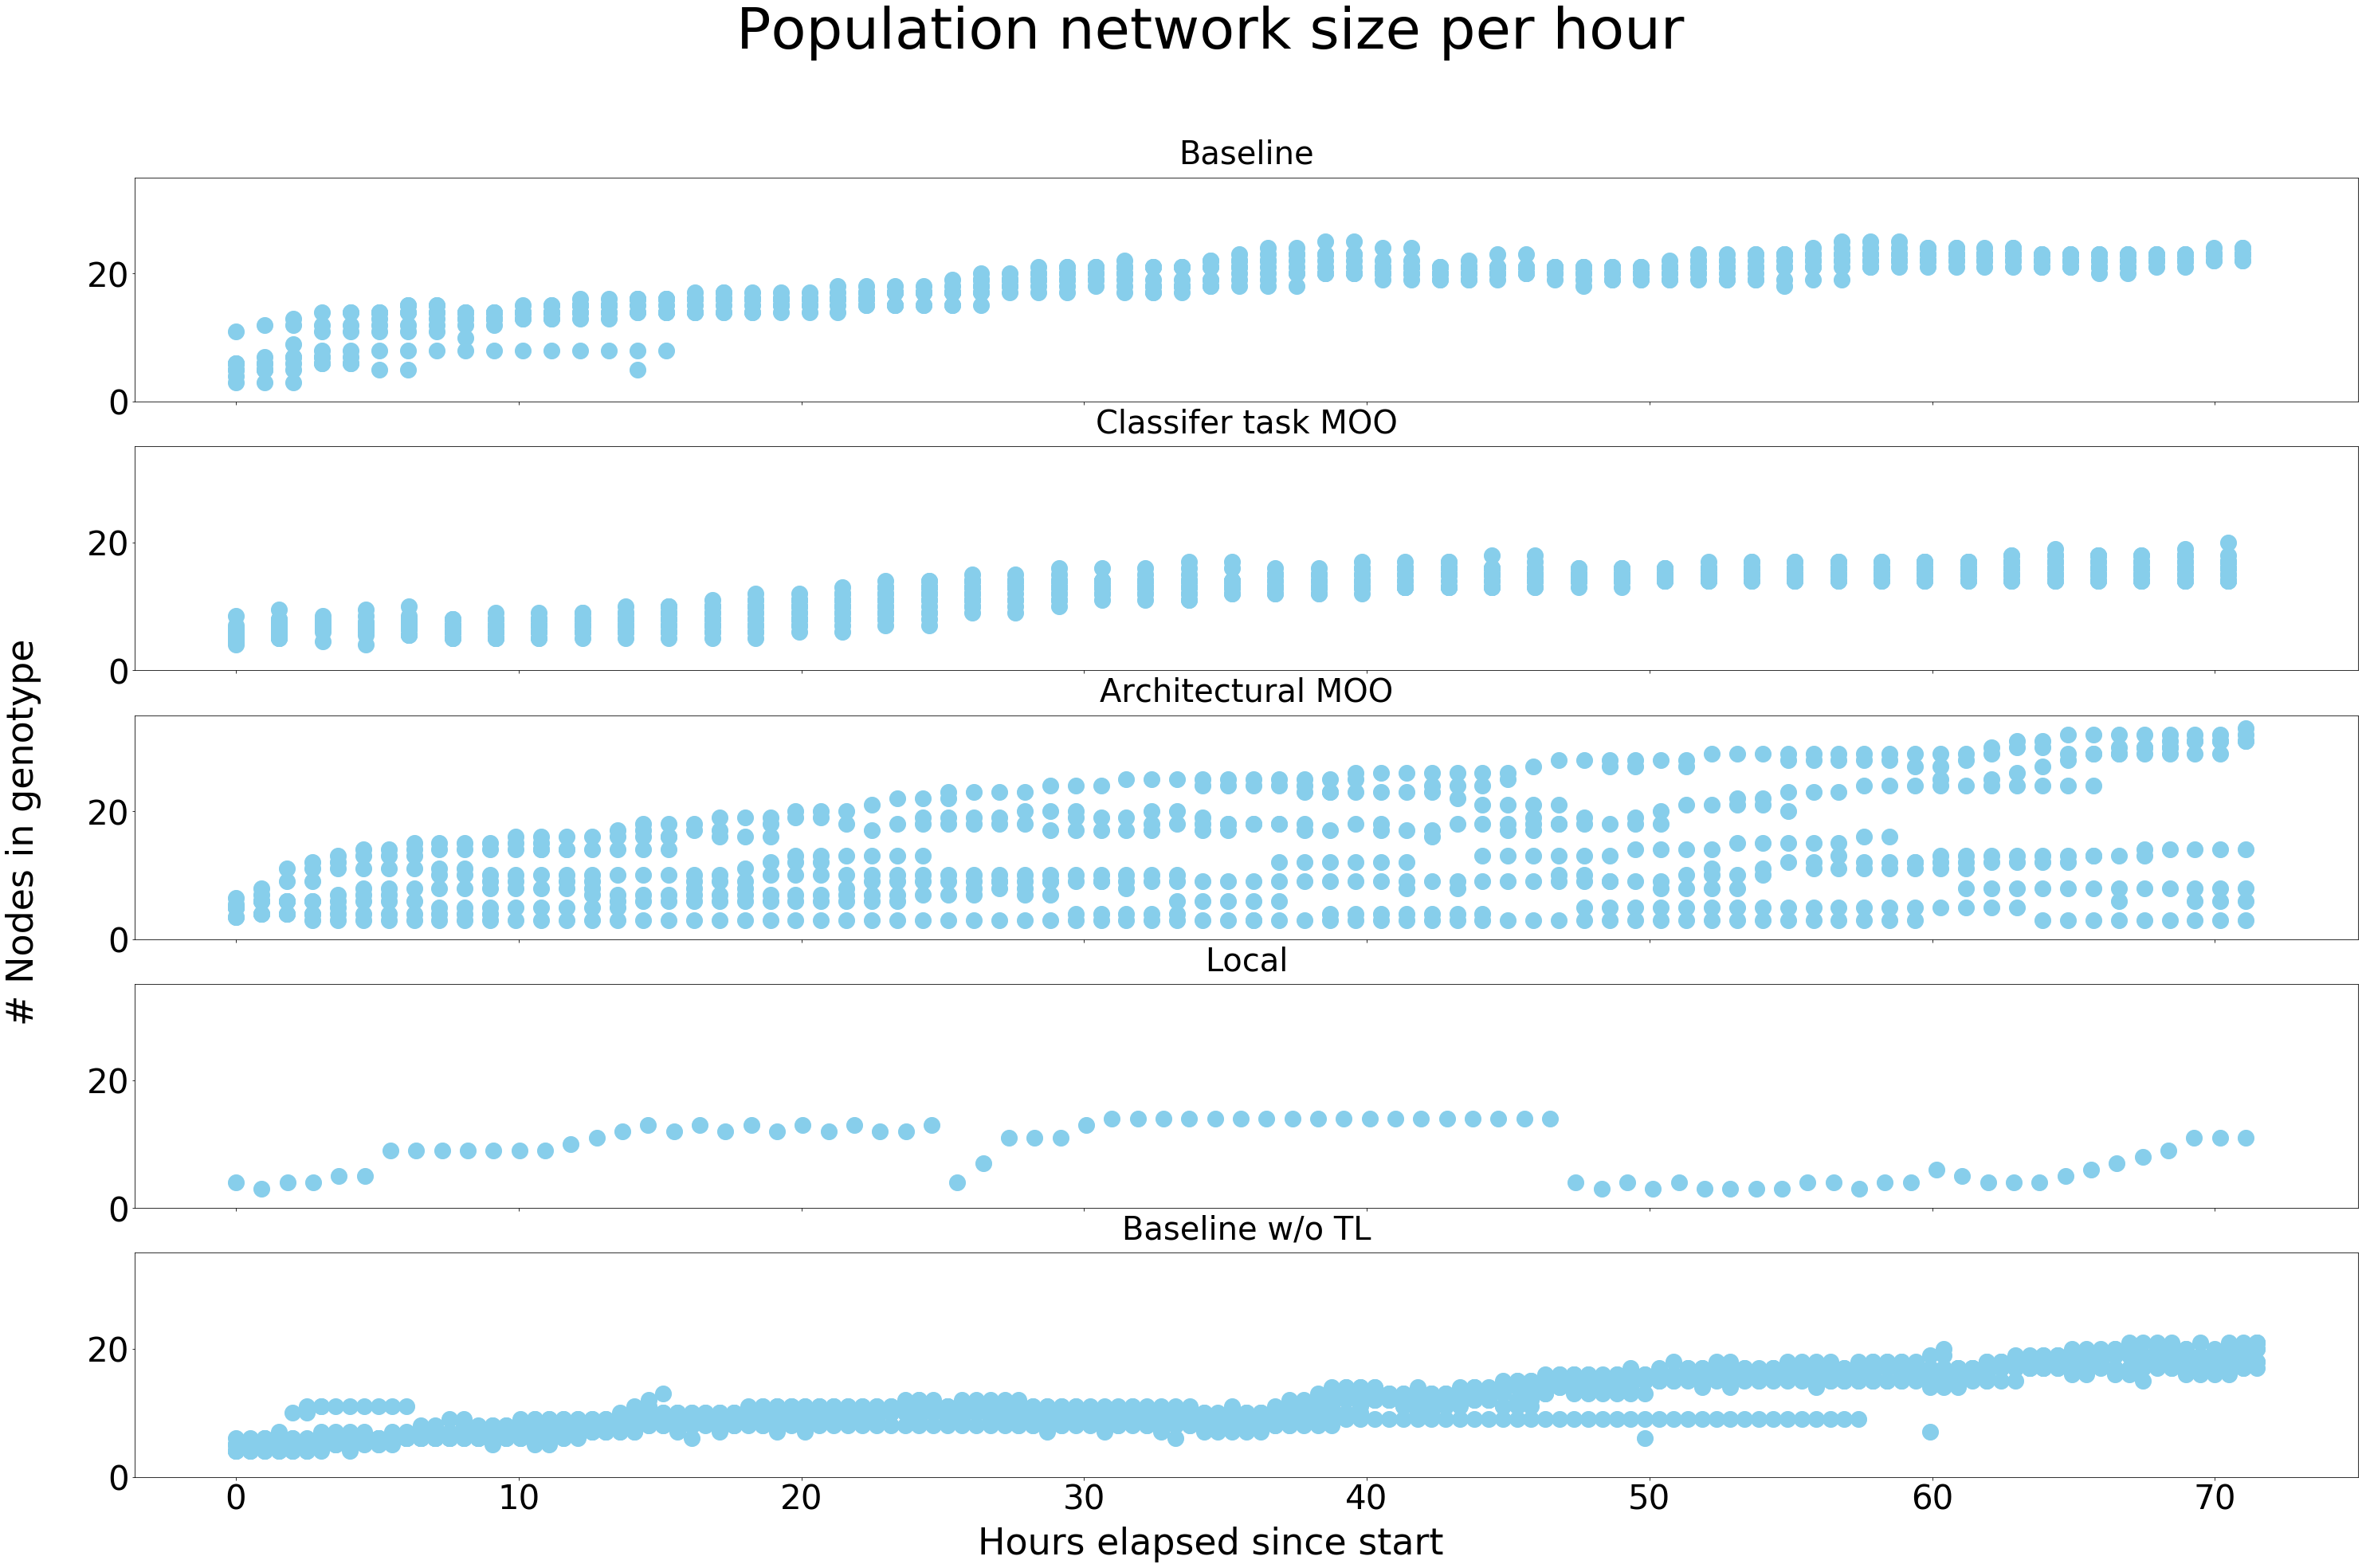

In [34]:
def plot_population_size_scatter(experiments, title="Population network size per hour"):
    fig, axs = plt.subplots(nrows=len(experiments), sharex=True)
    for exp, ax in zip(experiments, axs):
        generation_data = []
        gensize = len(exp.generations[int(len(exp.generations)/2)])
        for gen in exp.generations:        
            generation = [ind.number_of_operations() for ind in gen]
            if len(gen) > gensize:
                generation = [(generation[i] + generation[i+1]) / 2 for i in range(0, len(gen), 2)]
            generation_data.append(generation)

        generation_data = np.array(generation_data)
        hours = generations_to_hours(exp)

        ax.set_title(exp.name, y=1.04, fontsize=40)
        ax.set_ylim(0, 35)
        ax.plot(hours, generation_data, markersize=20, marker='o', linestyle="", color="skyblue")
    
    fig.suptitle(title, fontsize=72)
    fig.text(0.5, 0.08, 'Hours elapsed since start', ha='center', fontsize=46)
    fig.text(0.08, 0.5, '# Nodes in genotype', va='center', rotation='vertical', fontsize=46)
    plt.savefig(savedir(title))
plot_population_size_scatter([exp01, exp02, exp03, exp05, exp06])

# Playing with transfer learning data
* Find average lost knowledge in transfer learning with successor
* Follow the best overall through its entire training
* More cool stuff


In [35]:
def plot_transfer_learning_acc(exp):
    def reports_until_certain_epoch(module, epoch, previous_epochs):
        keys = list(module.report.keys())
        keys.sort()
        return [(key + previous_epochs, report) for key, report in module.report.items() if key <= epoch]
        
    def gather_recursivly(current, start_epoch):
        """ Traverse backwards gathering accuracies """
        epochs = current.fitness[:start_epoch]
        lines = [start_epoch]
        if current.predecessor:
            prior_epochs, prior_lines, prior_reports = gather_recursivly(
                current.predecessor, 
                current.immediate_transferred_knowledge_epochs
            )
            
            reports = reports_until_certain_epoch(current, start_epoch, len(prior_epochs))
            return prior_epochs + epochs, prior_lines + lines, reports + prior_reports
        return [], lines, []
        
    best = best_individ_in_generation(exp.generations[-1])
    for num, gen in enumerate(exp.generations):
        if f"{best.name} v0" in [x.ID for x in gen]:
            print(f"{best.name}, the best in the last population was first seen in generation {num}")
            break
    
    epochs, lines, reports = gather_recursivly(best, best.epochs_trained)
    
    cumulative_line_add = [sum(lines[:i]) for i in range(len(lines))]
    
    title = f"Training set accuracy over epochs for best individ ({exp.name})"
    ax = plt.subplot(111)
    ax.plot(range(len(epochs)), epochs, linewidth=7)
    plot_setup(ax, title, legend=False)
    
    for spawn in cumulative_line_add:
        ax.plot([spawn, spawn], [0, 1], lw=3, dashes=[2, 2], color="#000000")
        
    for epoch, report in reports:
        num = report['weighted avg']["precision"]
        ax.plot(epoch, num, lw=20, markersize=30, marker='o', color="#44ff44")
    ax.set_xlabel("Epochs trained")
    ax.set_ylabel("% Accuracy")
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.savefig(savedir(title))

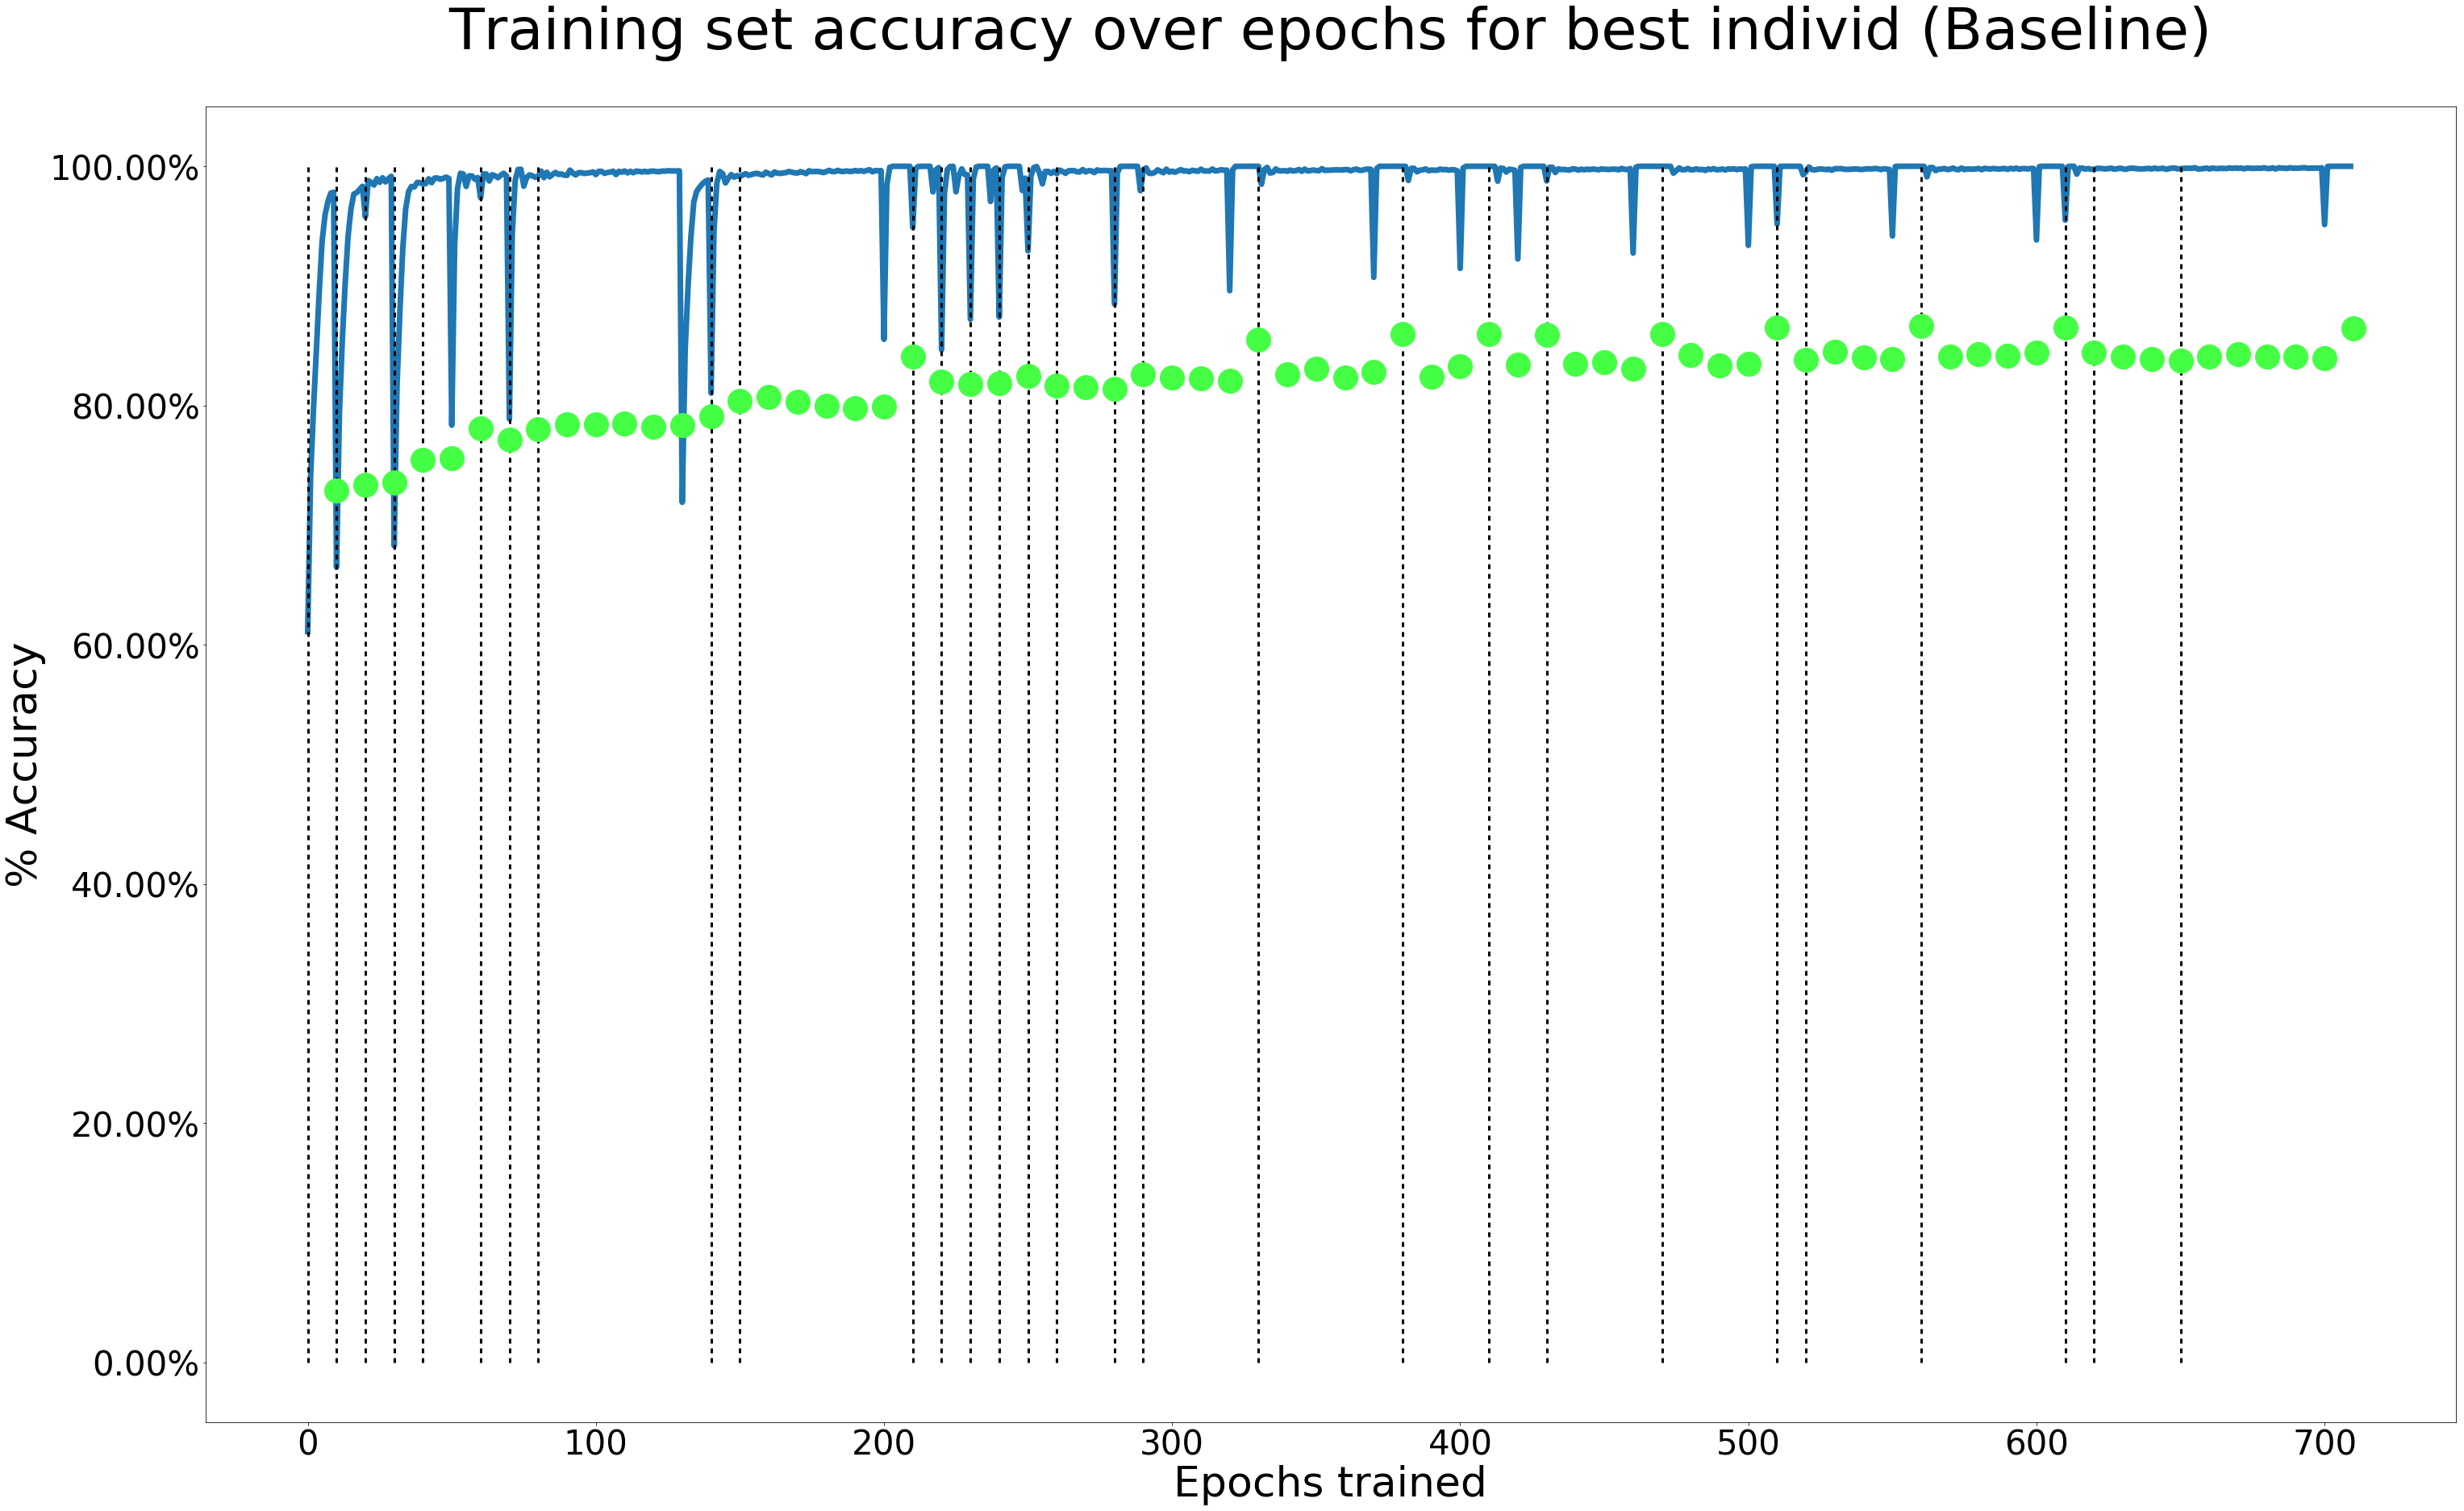

In [36]:
plot_transfer_learning_acc(exp01)

Noa, the best in the last population was first seen in generation 65


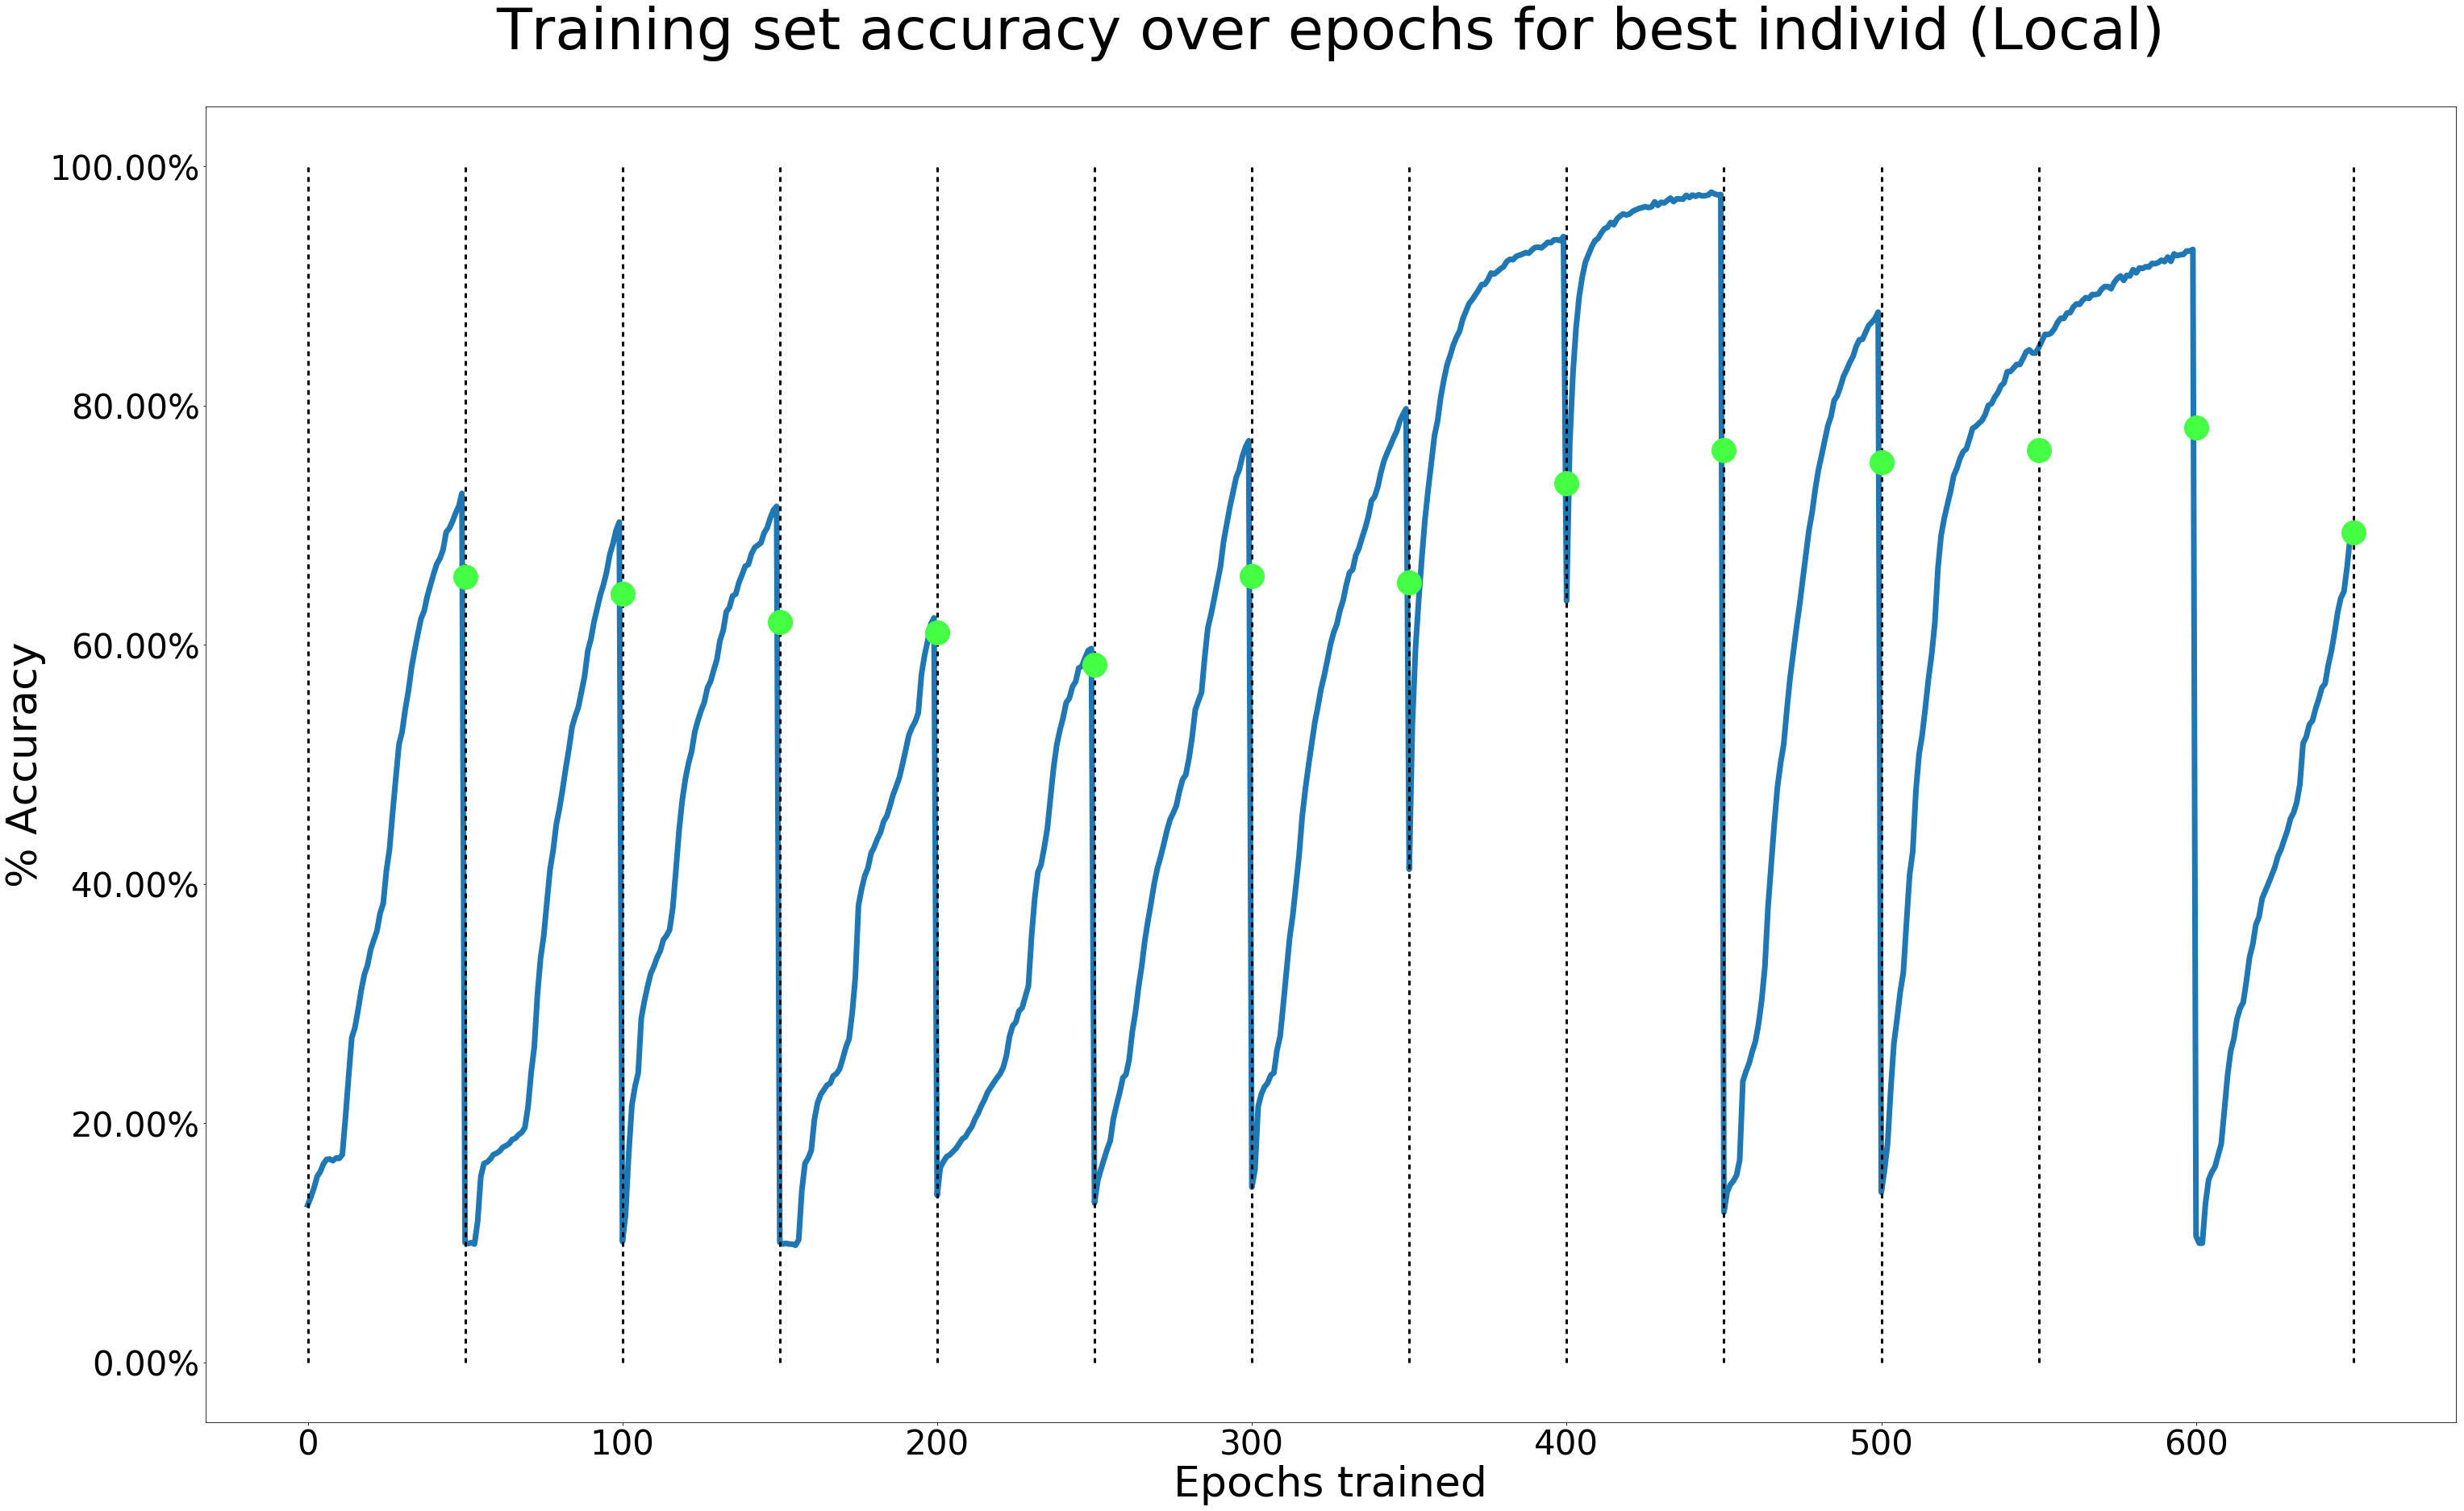

In [37]:
plot_transfer_learning_acc(exp05)


One note about the plot above, One epoch of training has to occur before any evaluation of training set can be gathered. This means loss between offspring and parent might be larger than it seems. 

# Analyzing Individual in population per generation

* Which are the best per experiment type
* How many newly spawned individuals are there per generation that survives?

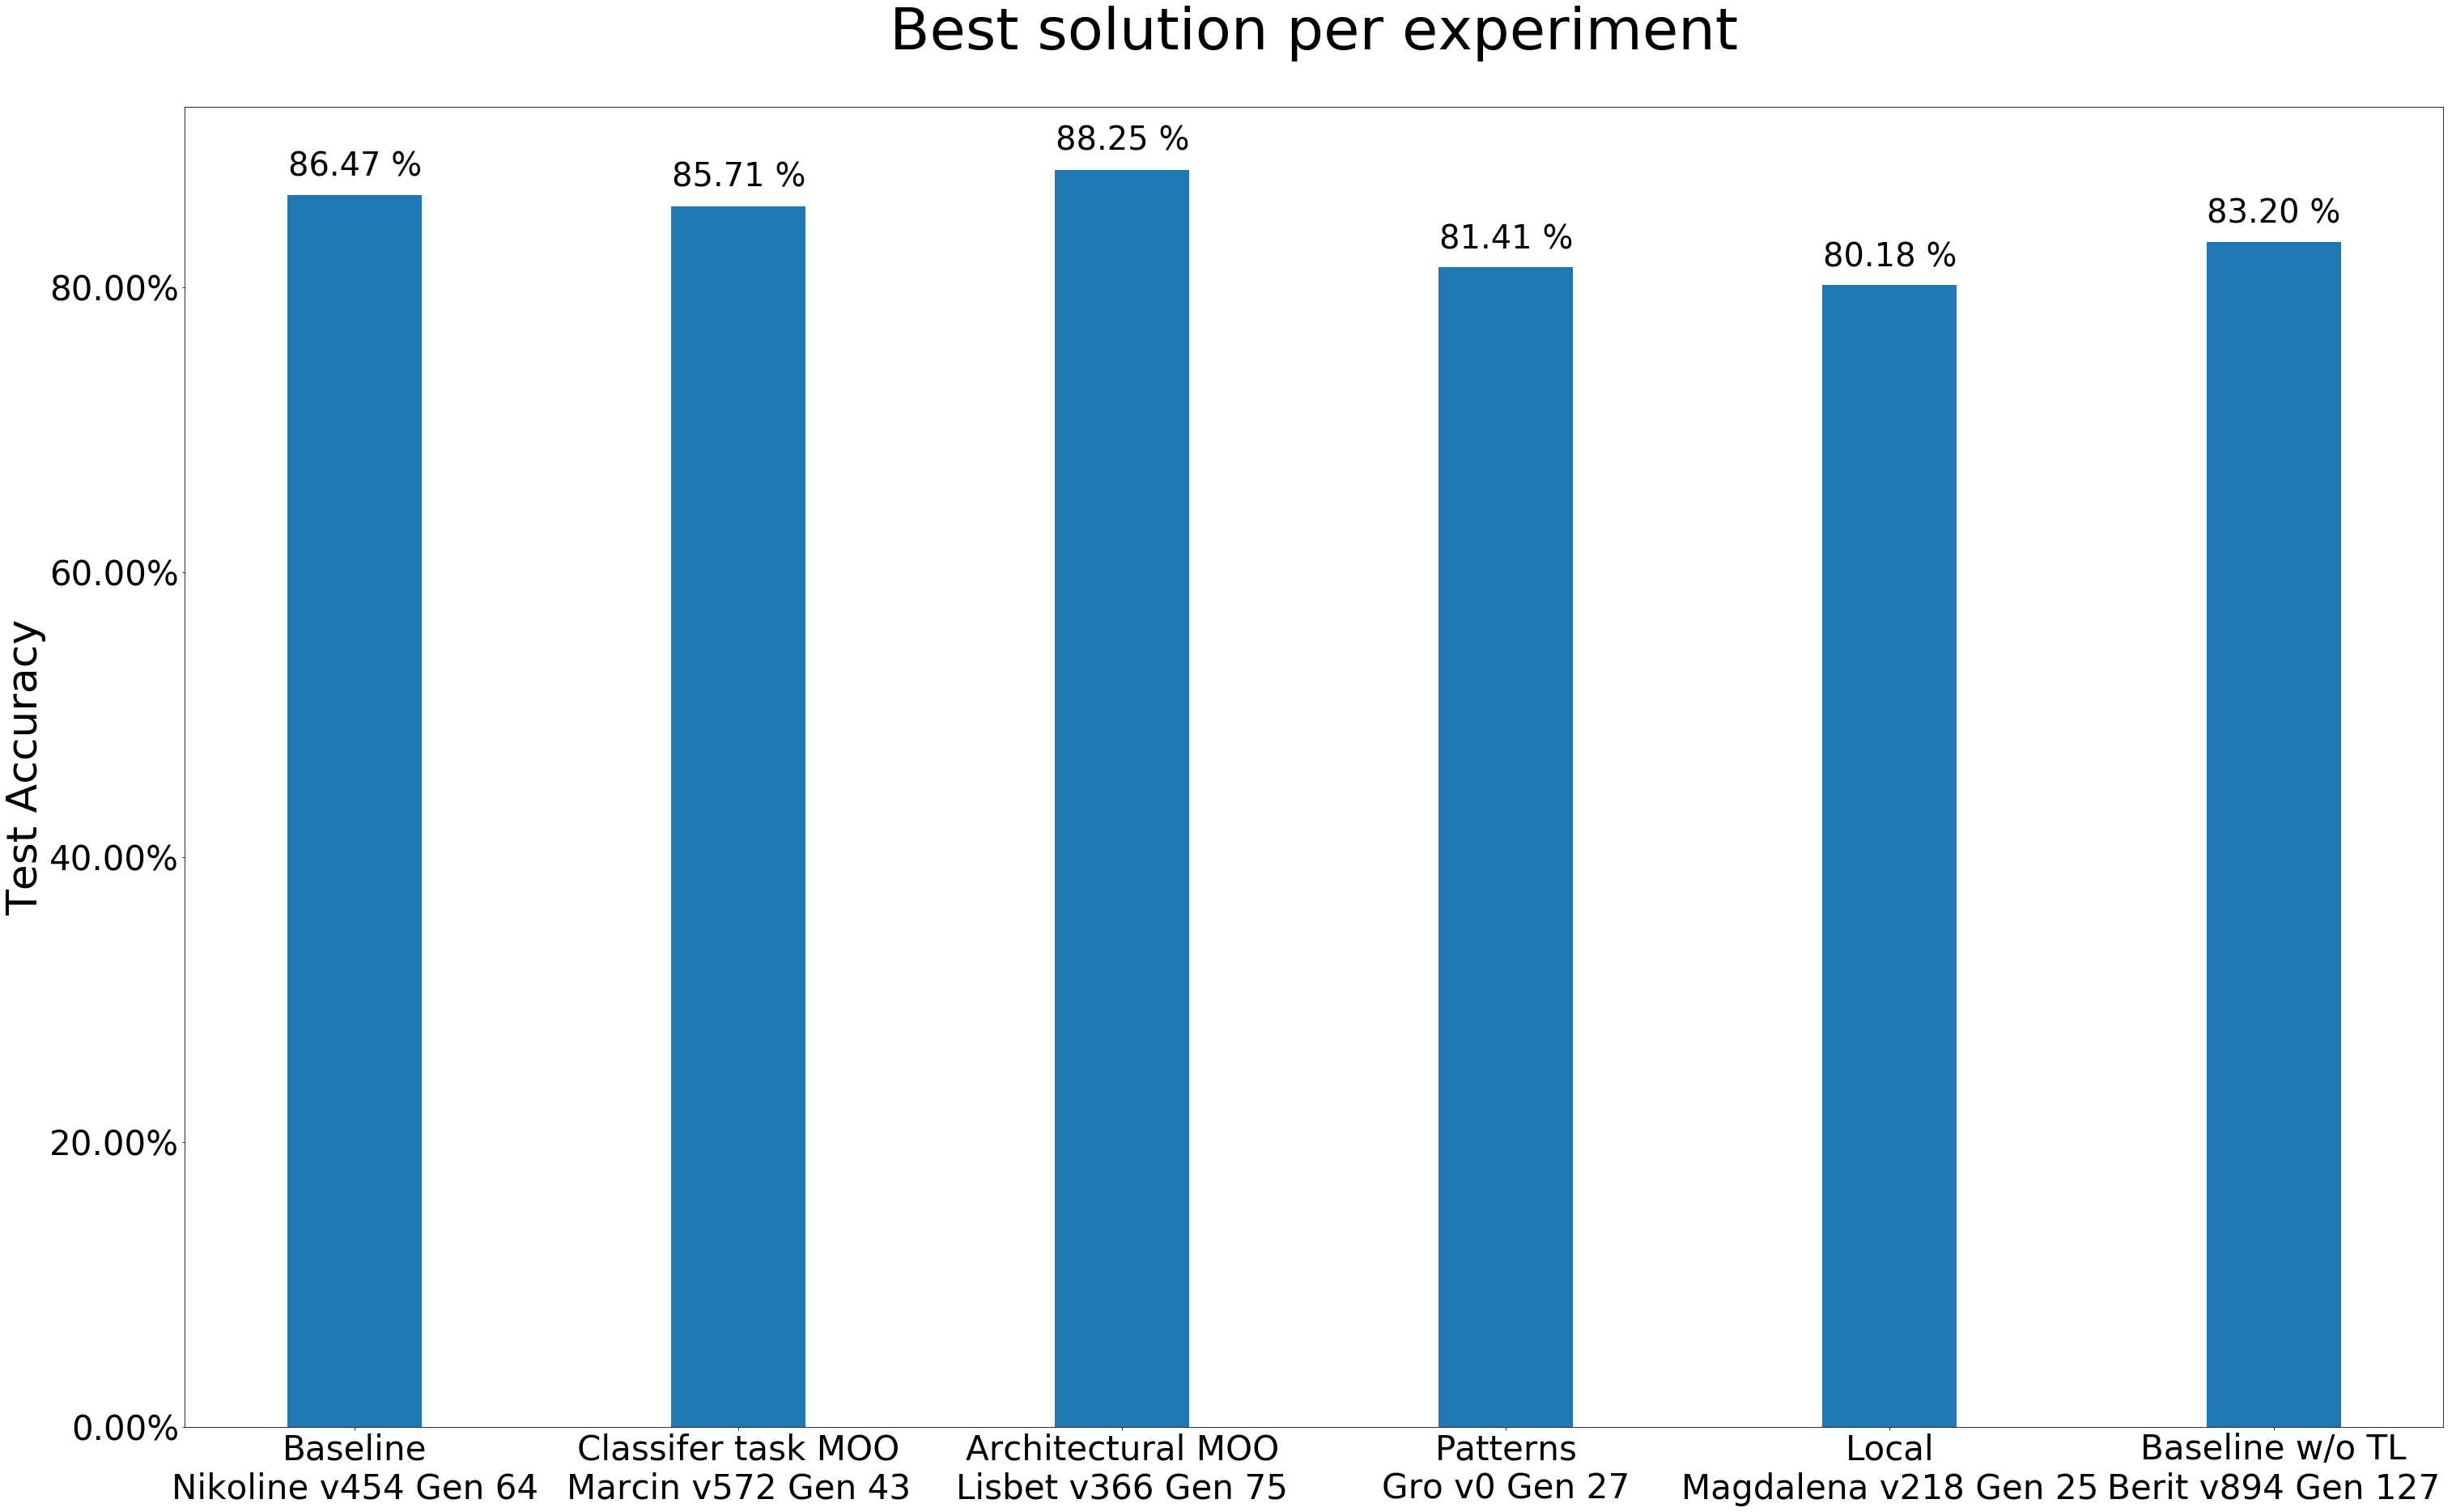

In [38]:
def plot_best_gene_per_experiment(experiments, title="Best solution per experiment"):
    width = 0.35  # the width of the bars
    ax = plt.subplot(111)

    bests = []
    gens = []
    for exp in experiments:
        best, gen = exp.alltime_best()
        bests += [best]
        gens += [gen]

    rects1 = ax.bar(
        [i for i in range(len(experiments))], 
        [round(best.test_acc(), 4) for best in bests],
        width
    )
    
    plot_setup(ax, title, legend=False, percent=True)
    ax.set_xticks([i for i in range(len(experiments))])
    ax.set_xticklabels([
        f"{exp.name}\n{best.ID} Gen {gen}" for exp, best, gen in zip(experiments, bests, gens)
    ])
    ax.set_ylabel("Test Accuracy")

    def autolabel(rectsx, xpos='center', title=''):
        """
        Attach a text label above each bar in *rects*, displaying its height.

        *xpos* indicates which side to place the text w.r.t. the center of
        the bar. It can be one of the following {'center', 'right', 'left'}.
        """

        xpos = xpos.lower()  # normalize the case of the parameter
        ha = {'center': 'center', 'right': 'left', 'left': 'right'}
        offset = {'center': -1.00, 'right': 1.00, 'left': 1.00}  # x_txt = x + w*off

        for rect in rectsx:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                    '{x:.2f} %'.format(x=height*100), ha=ha[xpos], va='bottom', fontsize=40)

    autolabel(rects1, xpos="left", title="Test Accuracy")
    plt.savefig(savedir(title))
plot_best_gene_per_experiment(experiments)

# Comparing entry difficulty:
Use baseline vs without transfer learning to discover ideas about how much chance there is of a mutated individual surviving in the population. The higher values, the more chance there is of an individual surviving. Surviving meaning a new mutation is replacing any of the previous generation because of better scoring. 

In [39]:
def new_strains_per_generation(exp):
    """ Finds how many mutations/spawns that are introduced at each generation"""
    new_strains = []
    prev_gen = None
    for gen in exp.generations:
        if not prev_gen:
            prev_gen = gen
            new_strains += [1.00]
            continue
        
        # Finding change between generations:
        strains = 0
        for ind in gen:
            if not ind in prev_gen:
                strains += 1
        new_strains += [strains / exp.config.population_size]
        
        prev_gen = gen
        
    return new_strains

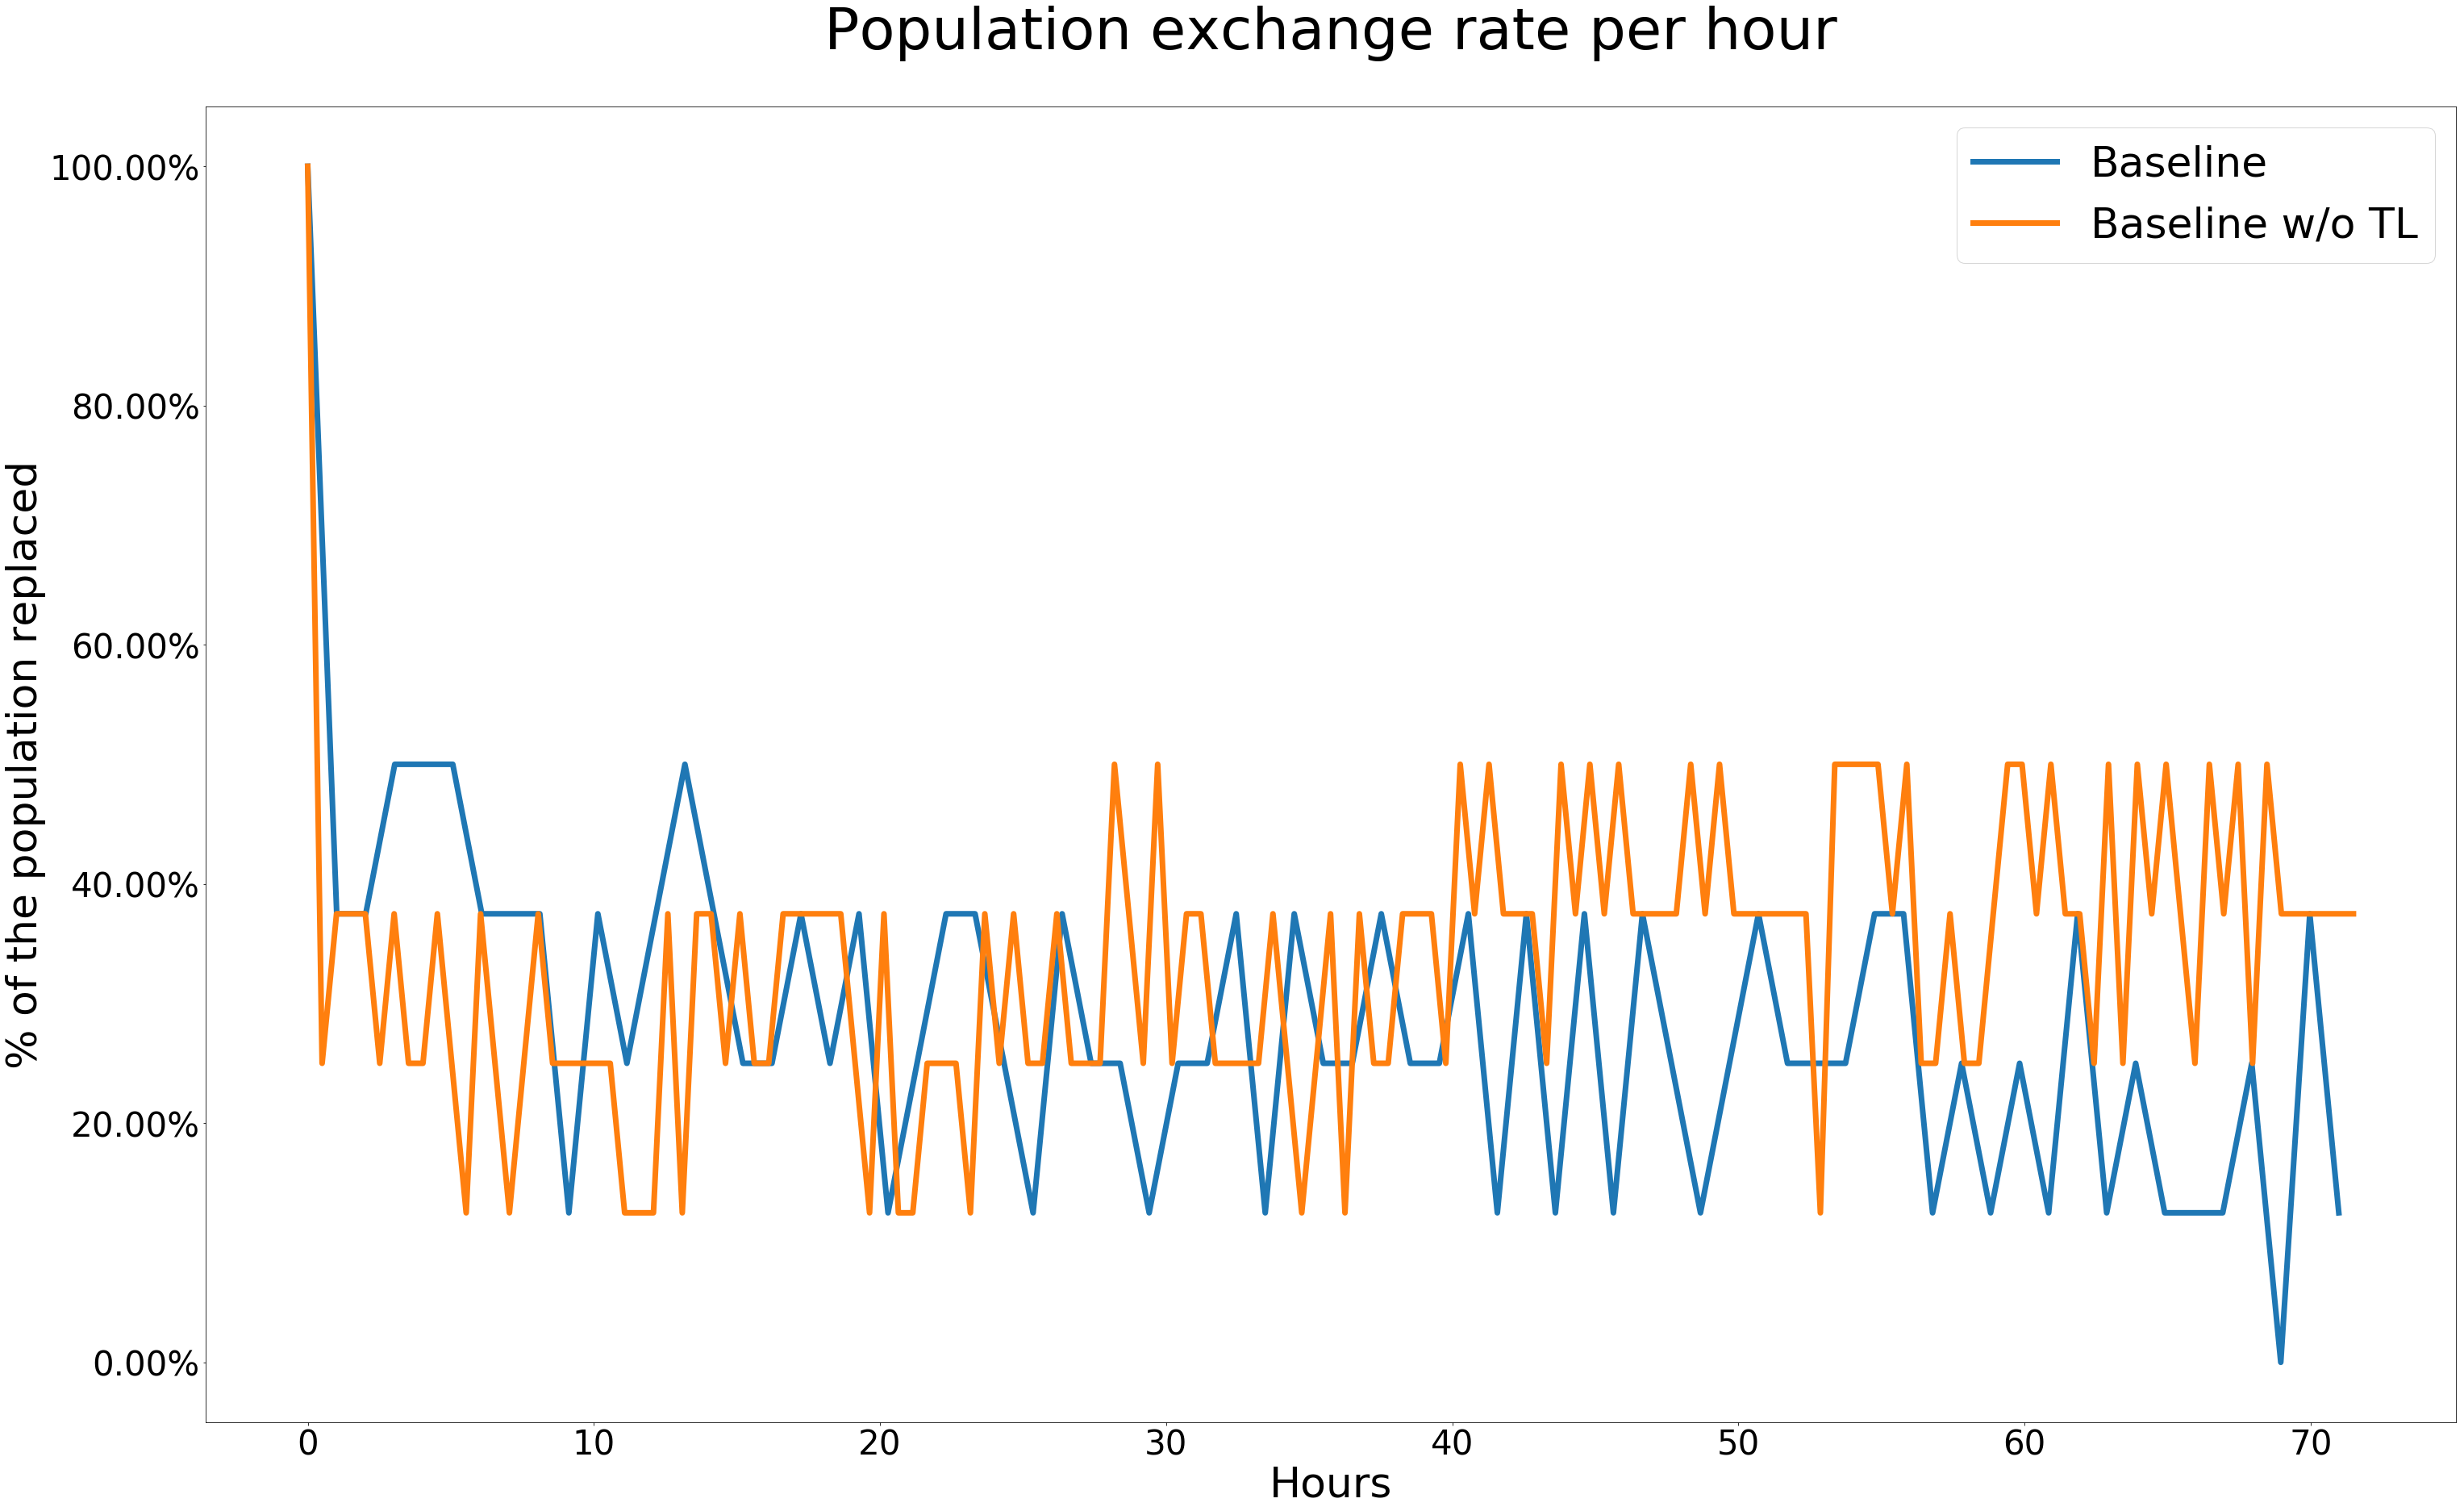

In [40]:
def exchange_rate_plot(experiments, title="Population exchange rate per hour"):
    ax = plt.subplot(111)
    x = [new_strains_per_generation(exp) for exp in experiments]
    y = [generations_to_hours(exp) for exp in experiments]
    labels = [exp.name for exp in experiments]
    plotter(
        x, 
        y, 
        title=title, 
        labels=labels, 
        percent=True,
        xaxis_title="Hours", 
        yaxis_title="% of the population replaced"
    )
exchange_rate_plot([exp01, exp06])

#### Strains functions
* Can be seen as how good is the exploration?

# Looking at the multi-objective pareto fronts

* An important note here is that 33.3% of every generation is removed. This means there could have been other fronts where there is only one. 


In [41]:
from src.MOOA import NSGA_II

def frontier_data(exp, domination_op, objectives):
    number_of_fronts = []
    for generation in exp.generations:
        frontieers = NSGA_II.fast_non_dominated_sort(generation, domination_op(objectives))
        n_fronts = len(frontieers)
        if len(frontieers[-1]) == 0:
            n_fronts -= 1
        number_of_fronts += [n_fronts]
    gens = generations_to_hours(exp)
    return number_of_fronts, gens
    

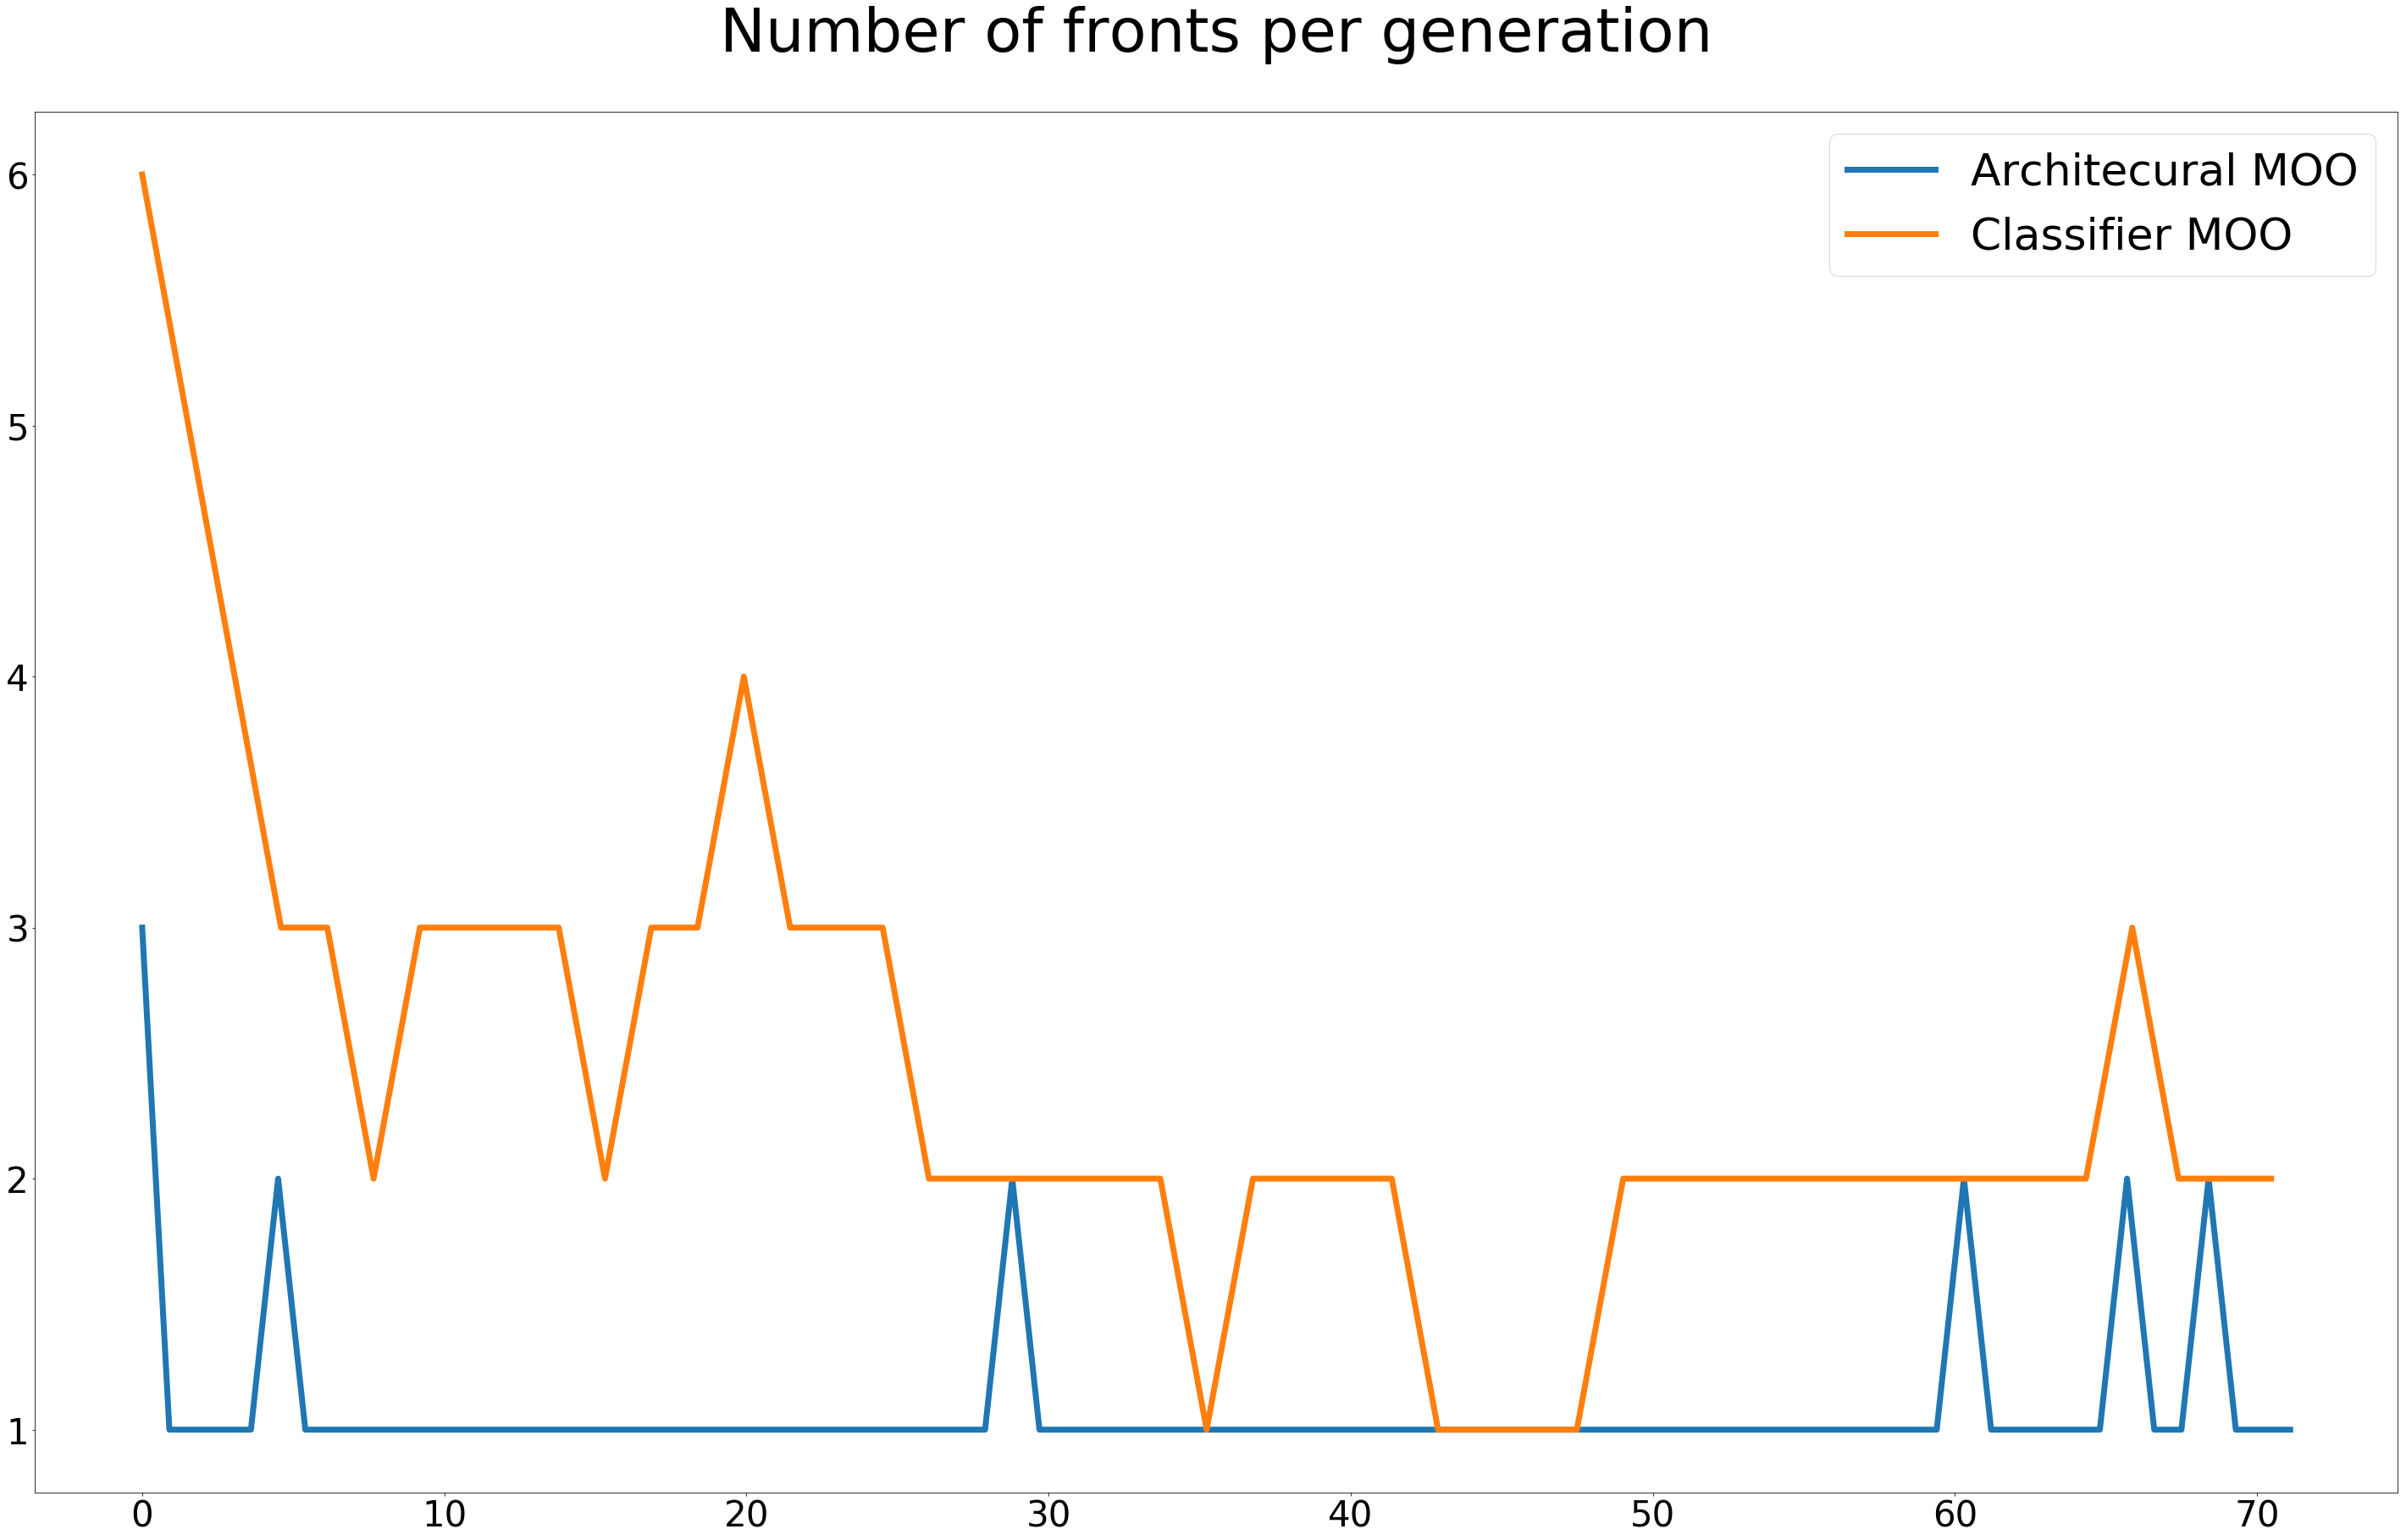

In [42]:
from src.ea_nas.moo_operators import architectural
x, y = frontier_data(
    exp03, 
    architectural.domination_operator, 
    architectural.objectives()
)

from src.ea_nas.moo_operators import classification_tasks
xx, yy = frontier_data(
    exp02, 
    classification_tasks.domination_operator, 
    classification_tasks.objectives(exp02.config)
)


labels=["Architecural MOO", "Classifier MOO"]
plotter([x, xx], [y, yy], title=f"Number of fronts per generation", labels=labels, legend=True)

Seeing as there are much higher number of fronts in Classifier task MOO than seen in Architectural MOO. As stated in section \ref{}, with objectives used in the multi-objective optimization algorithm, the harder it is to achieve domination. This indicates that there is some truth to the statement. Also of note here, this plot does not contain the non-surviving part of the population at each hour, meaning there could have been more fronts than displayed in the plot found in figure \ref{}.

In [43]:
from src.ea_nas.moo_operators import architectural

def measure_branching_factor(experiments, title="Most branching individual in population"):
    branching_factor = architectural.objectives()[1]
    fig, axs = plt.subplots(nrows=len(experiments), sharex=True)
    
    
    for ax, exp in zip(axs, experiments):
        branching, sizes = [], []
        for gen in exp.generations:
            max_branching, max_ind = None, None
            for ind in gen:
                current = branching_factor(ind)
                if not max_branching or not max_ind:
                    max_ind = ind
                    max_branching = current
                elif current > max_branching:
                    max_branching = current
                    max_ind = ind
            branching += [max_branching]
            sizes += [max_ind.number_of_operations()]
        hours = generations_to_hours(exp)
        
        ax.set_title(exp.name, fontsize=46, y=1.05)
        ax.plot(hours, branching)
        ax.plot(hours, sizes)
        ax.set_ylim(0, 30)
    fig.suptitle(title, fontsize=72)
    fig.text(0.5, 0.08, 'Hours elapsed since start', ha='center', fontsize=46)
    fig.text(0.08, 0.5, '# of branches', va='center', rotation='vertical', fontsize=46)
    plt.savefig(savedir(title))

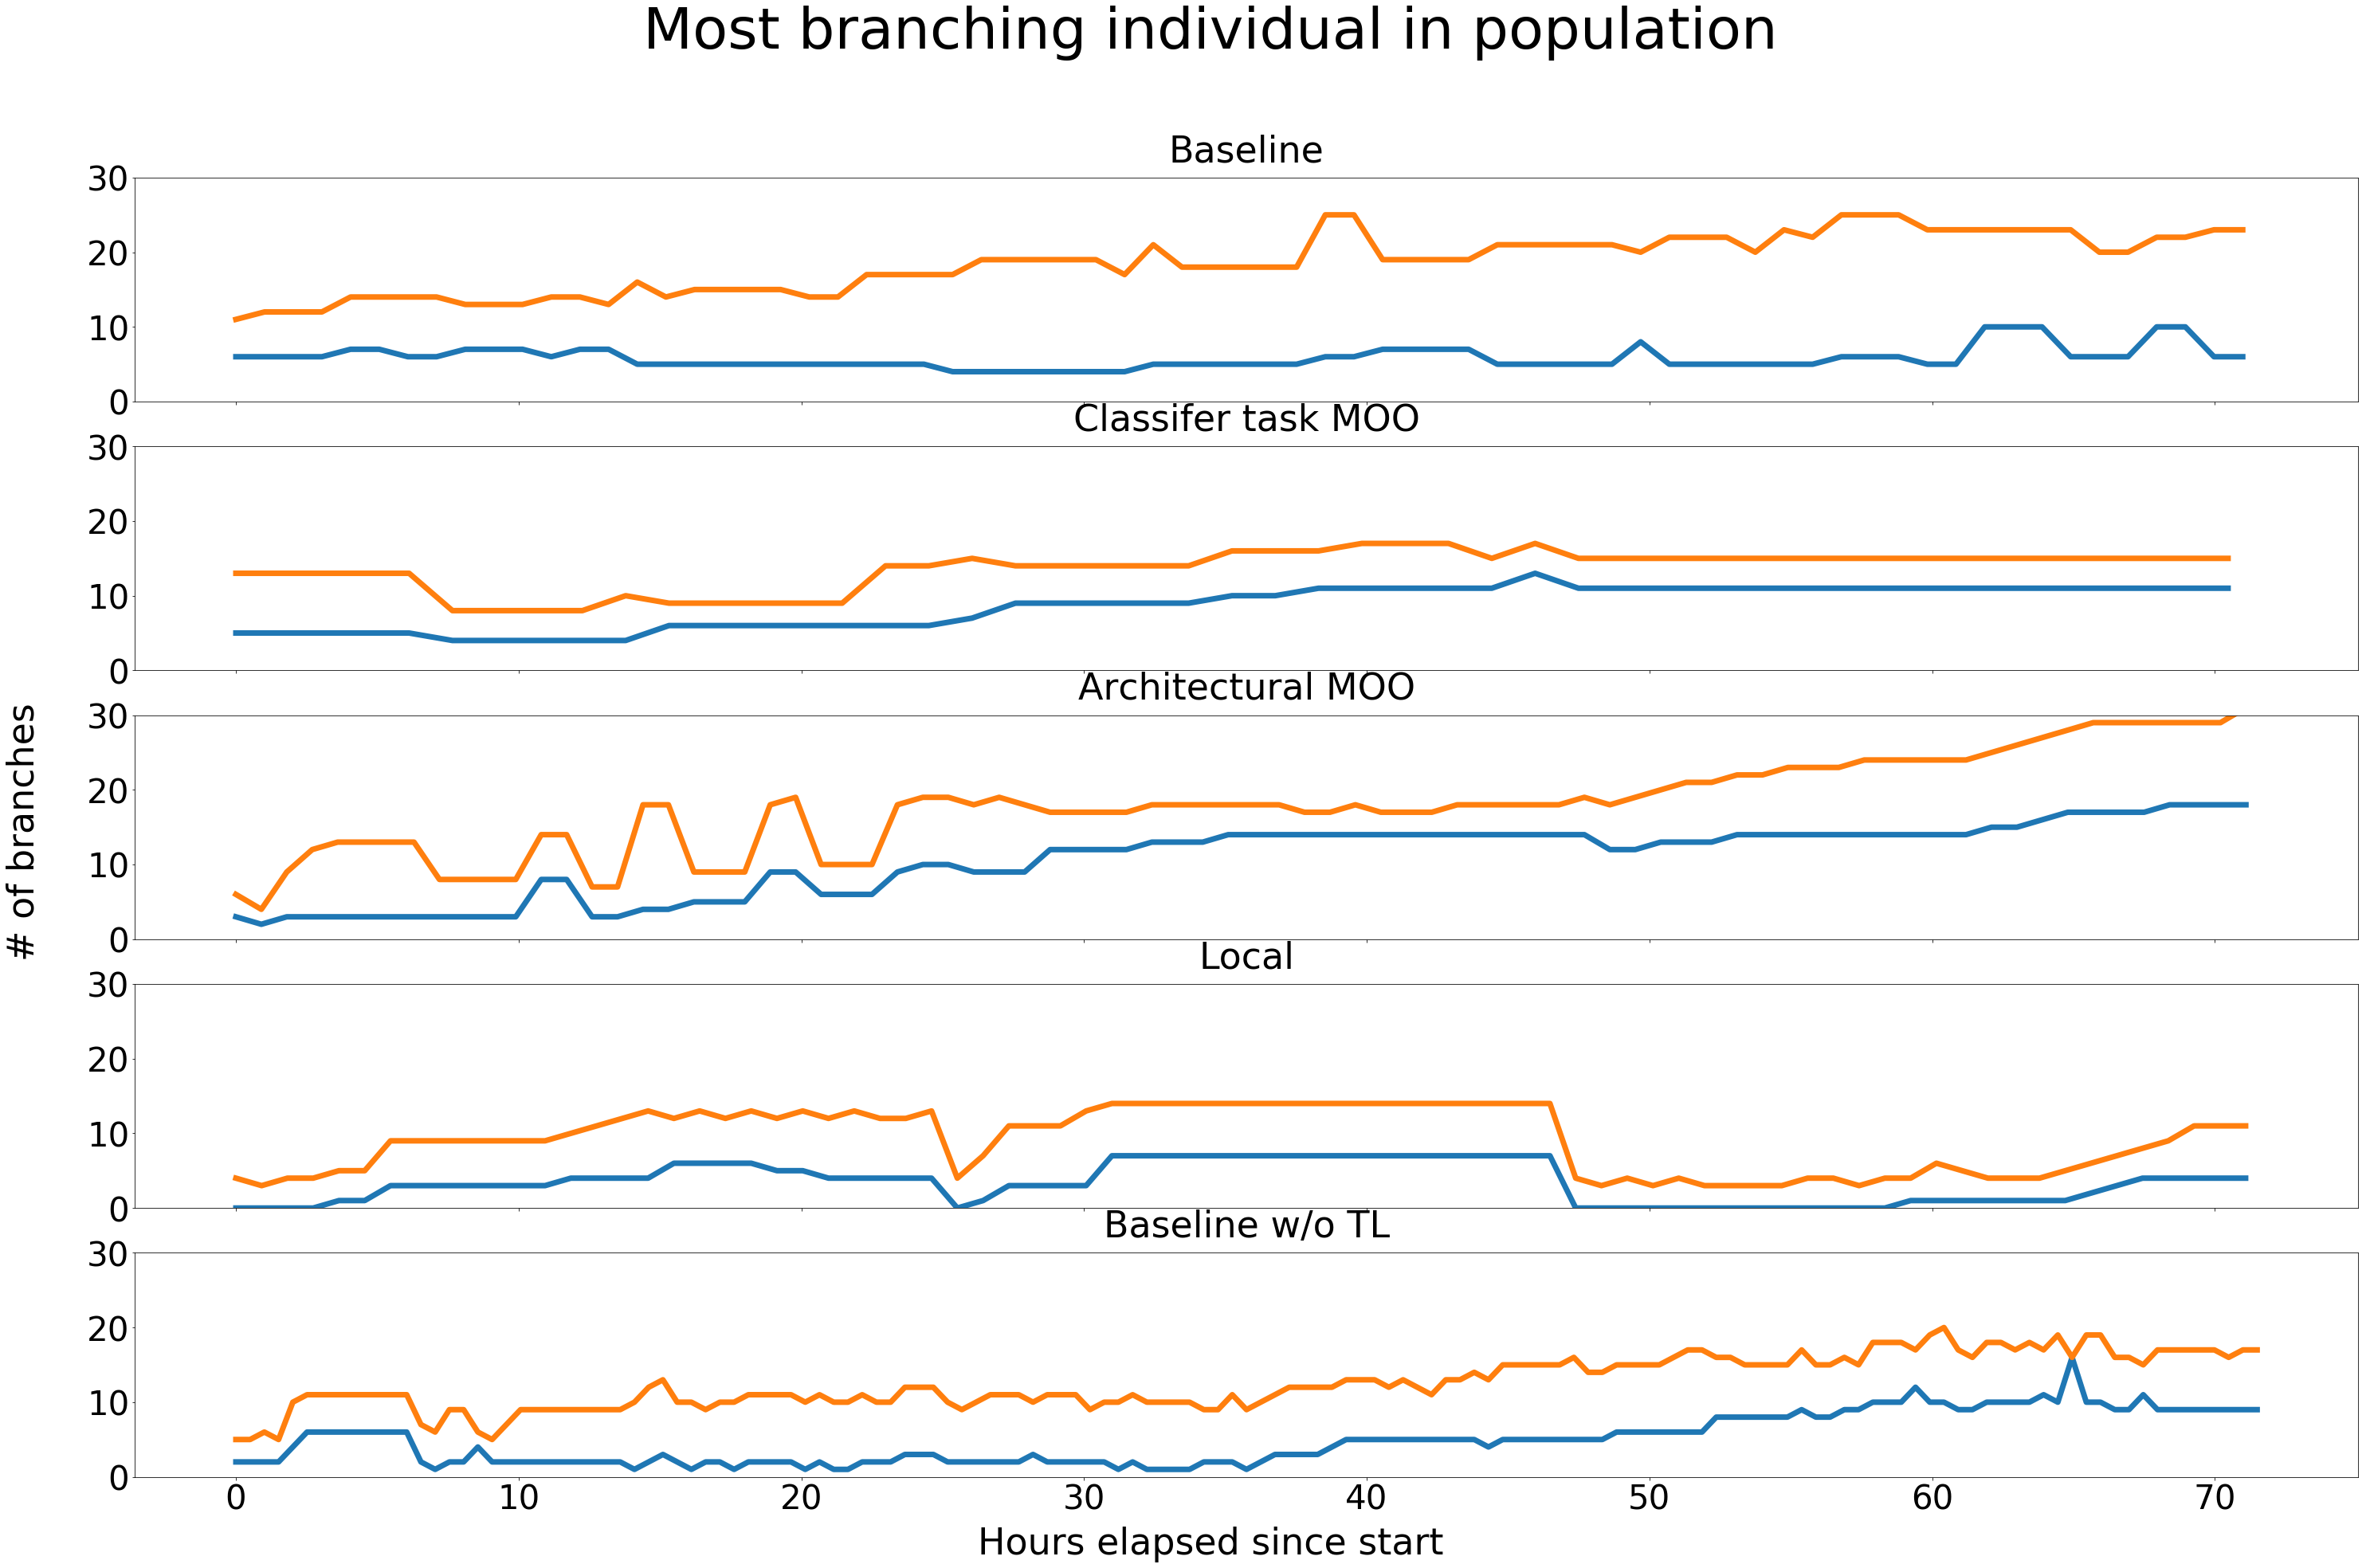

In [44]:
measure_branching_factor([exp01, exp02, exp03, exp05, exp06])

# STD deviation and Variance coefficient

AxesSubplot(0.125,0.536818;0.227941x0.343182)
AxesSubplot(0.398529,0.536818;0.227941x0.343182)
AxesSubplot(0.672059,0.536818;0.227941x0.343182)
AxesSubplot(0.125,0.125;0.227941x0.343182)
AxesSubplot(0.398529,0.125;0.227941x0.343182)
AxesSubplot(0.672059,0.125;0.227941x0.343182)


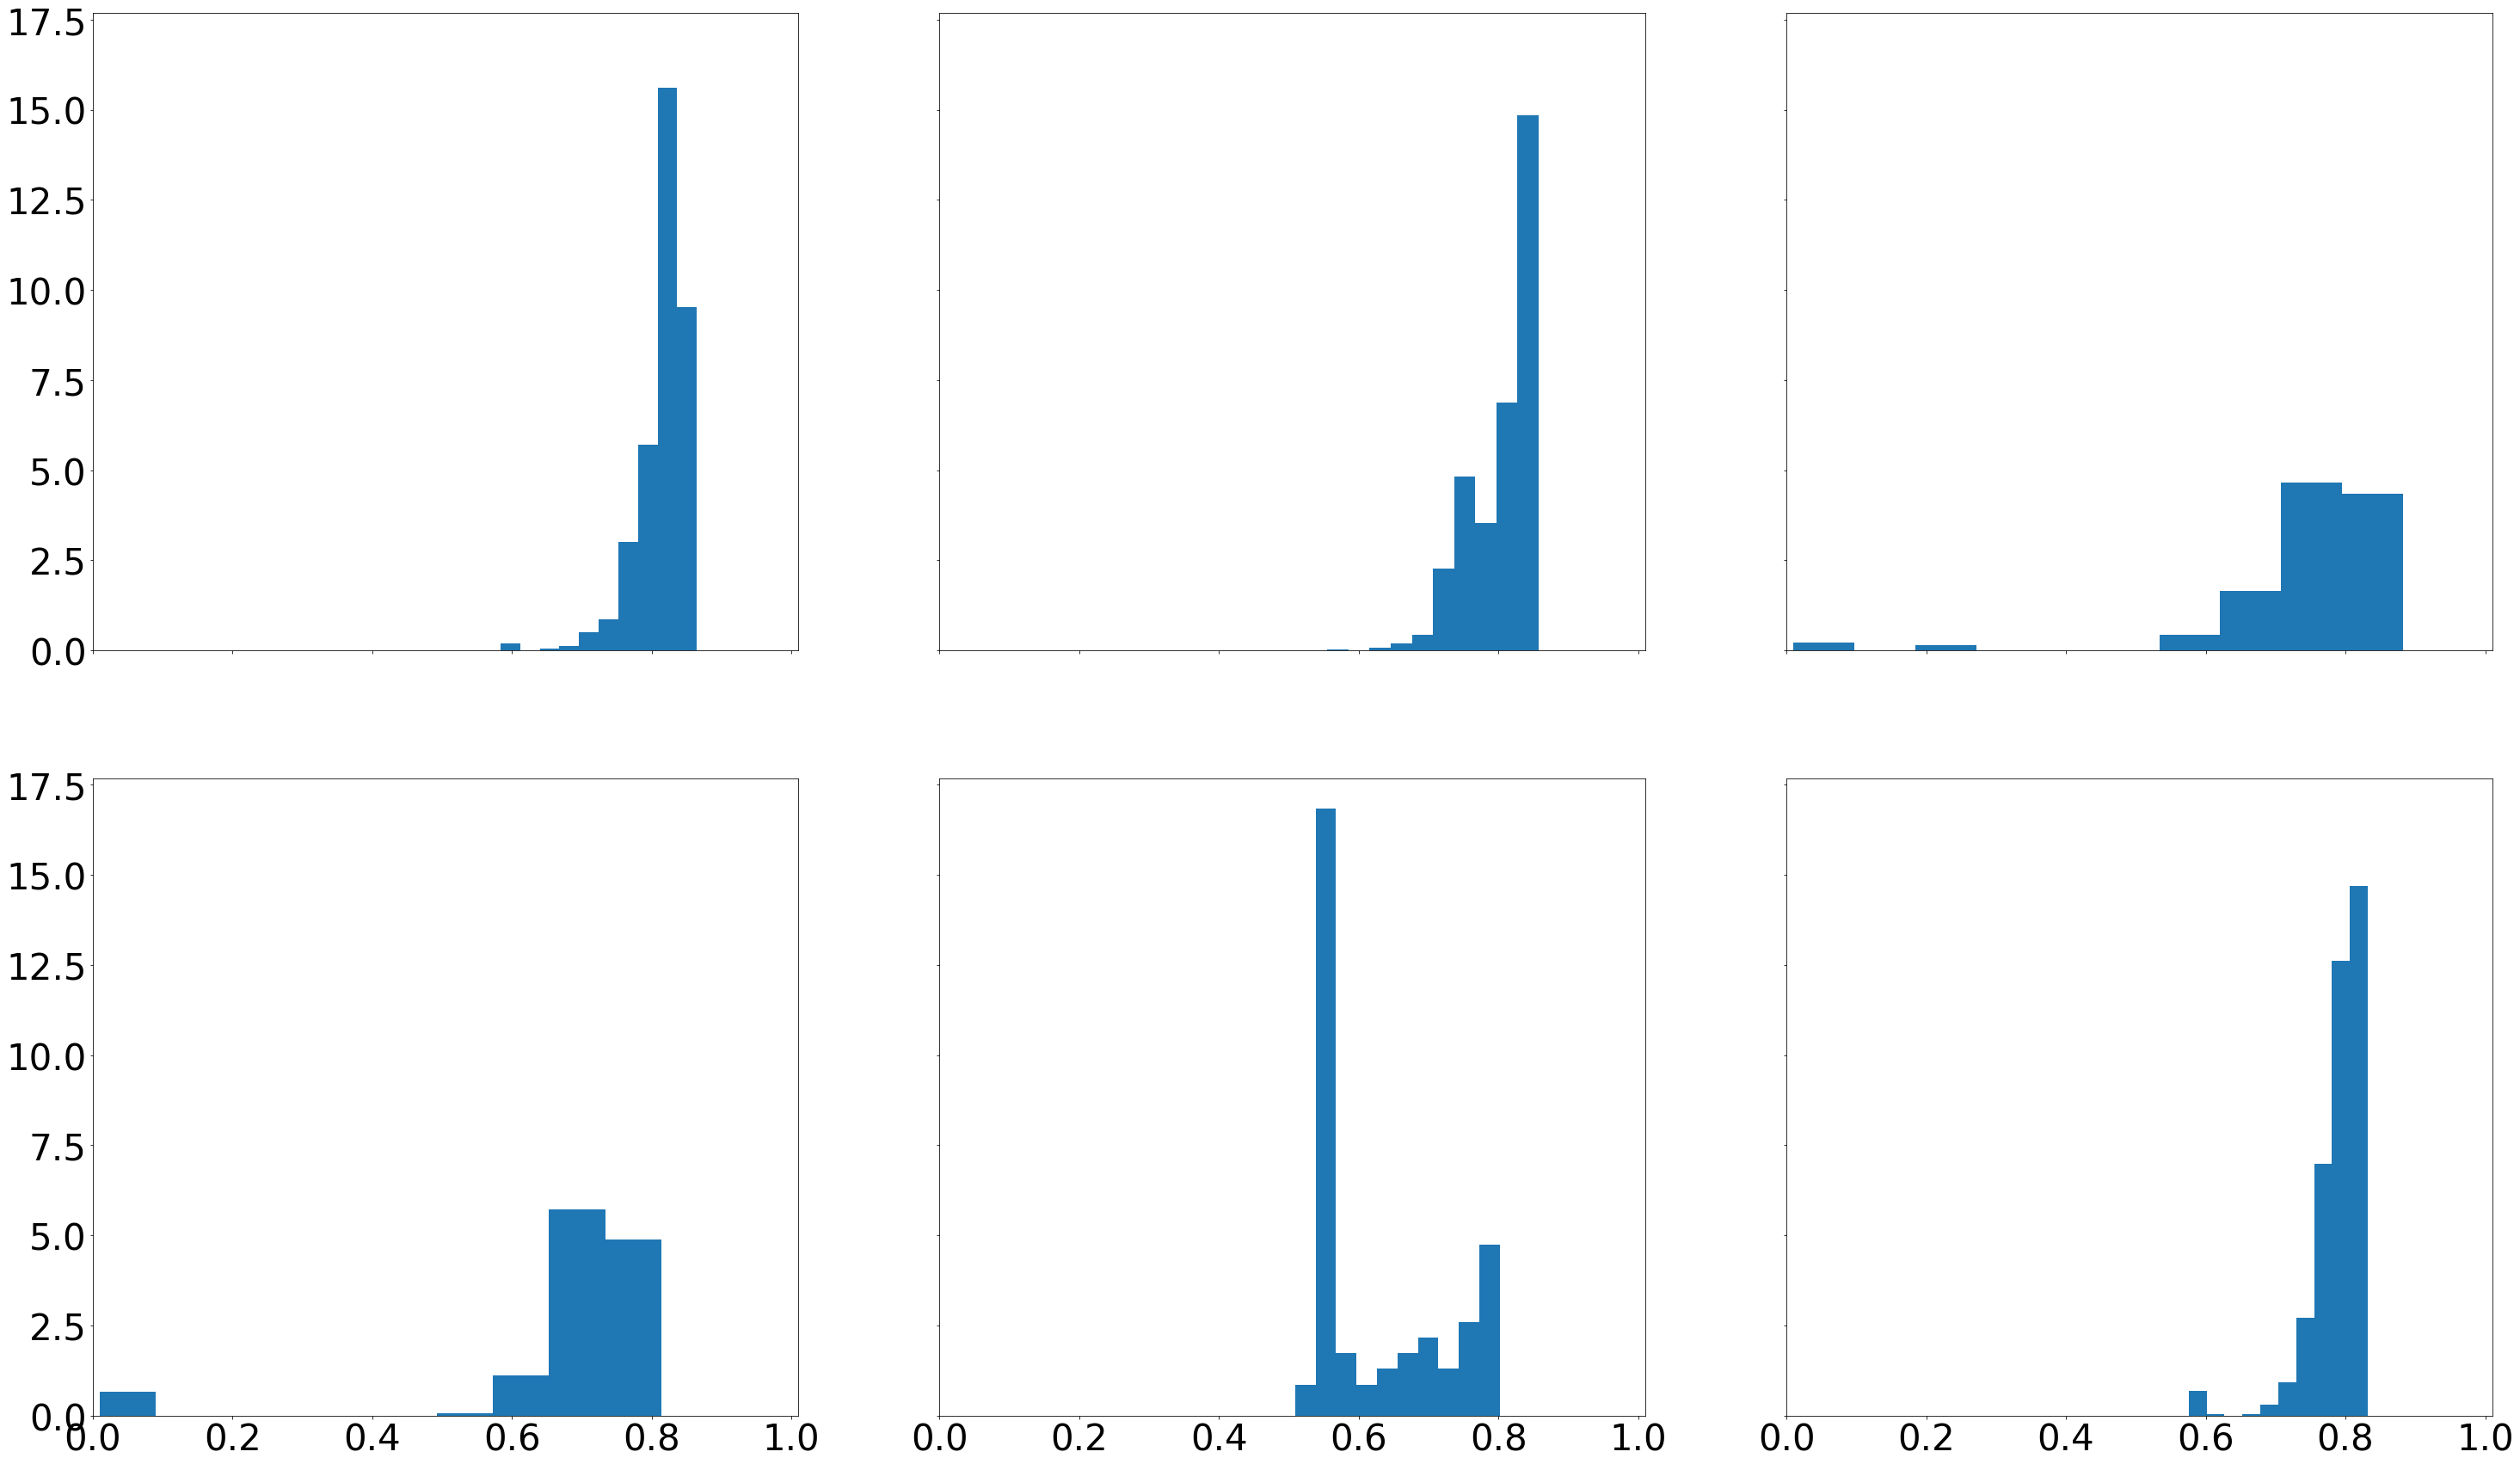

In [90]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True)
axs = [ax for x in axs for ax in x]
for exp, ax in zip(experiments, axs):
    print(ax)
    ax.hist(
        [ind.test_acc() for gen in exp.generations for ind in gen], 
        density=True, 
        histtype='stepfilled', 
        alpha=1
    )
    ax.set_xlim(0, 1.01)

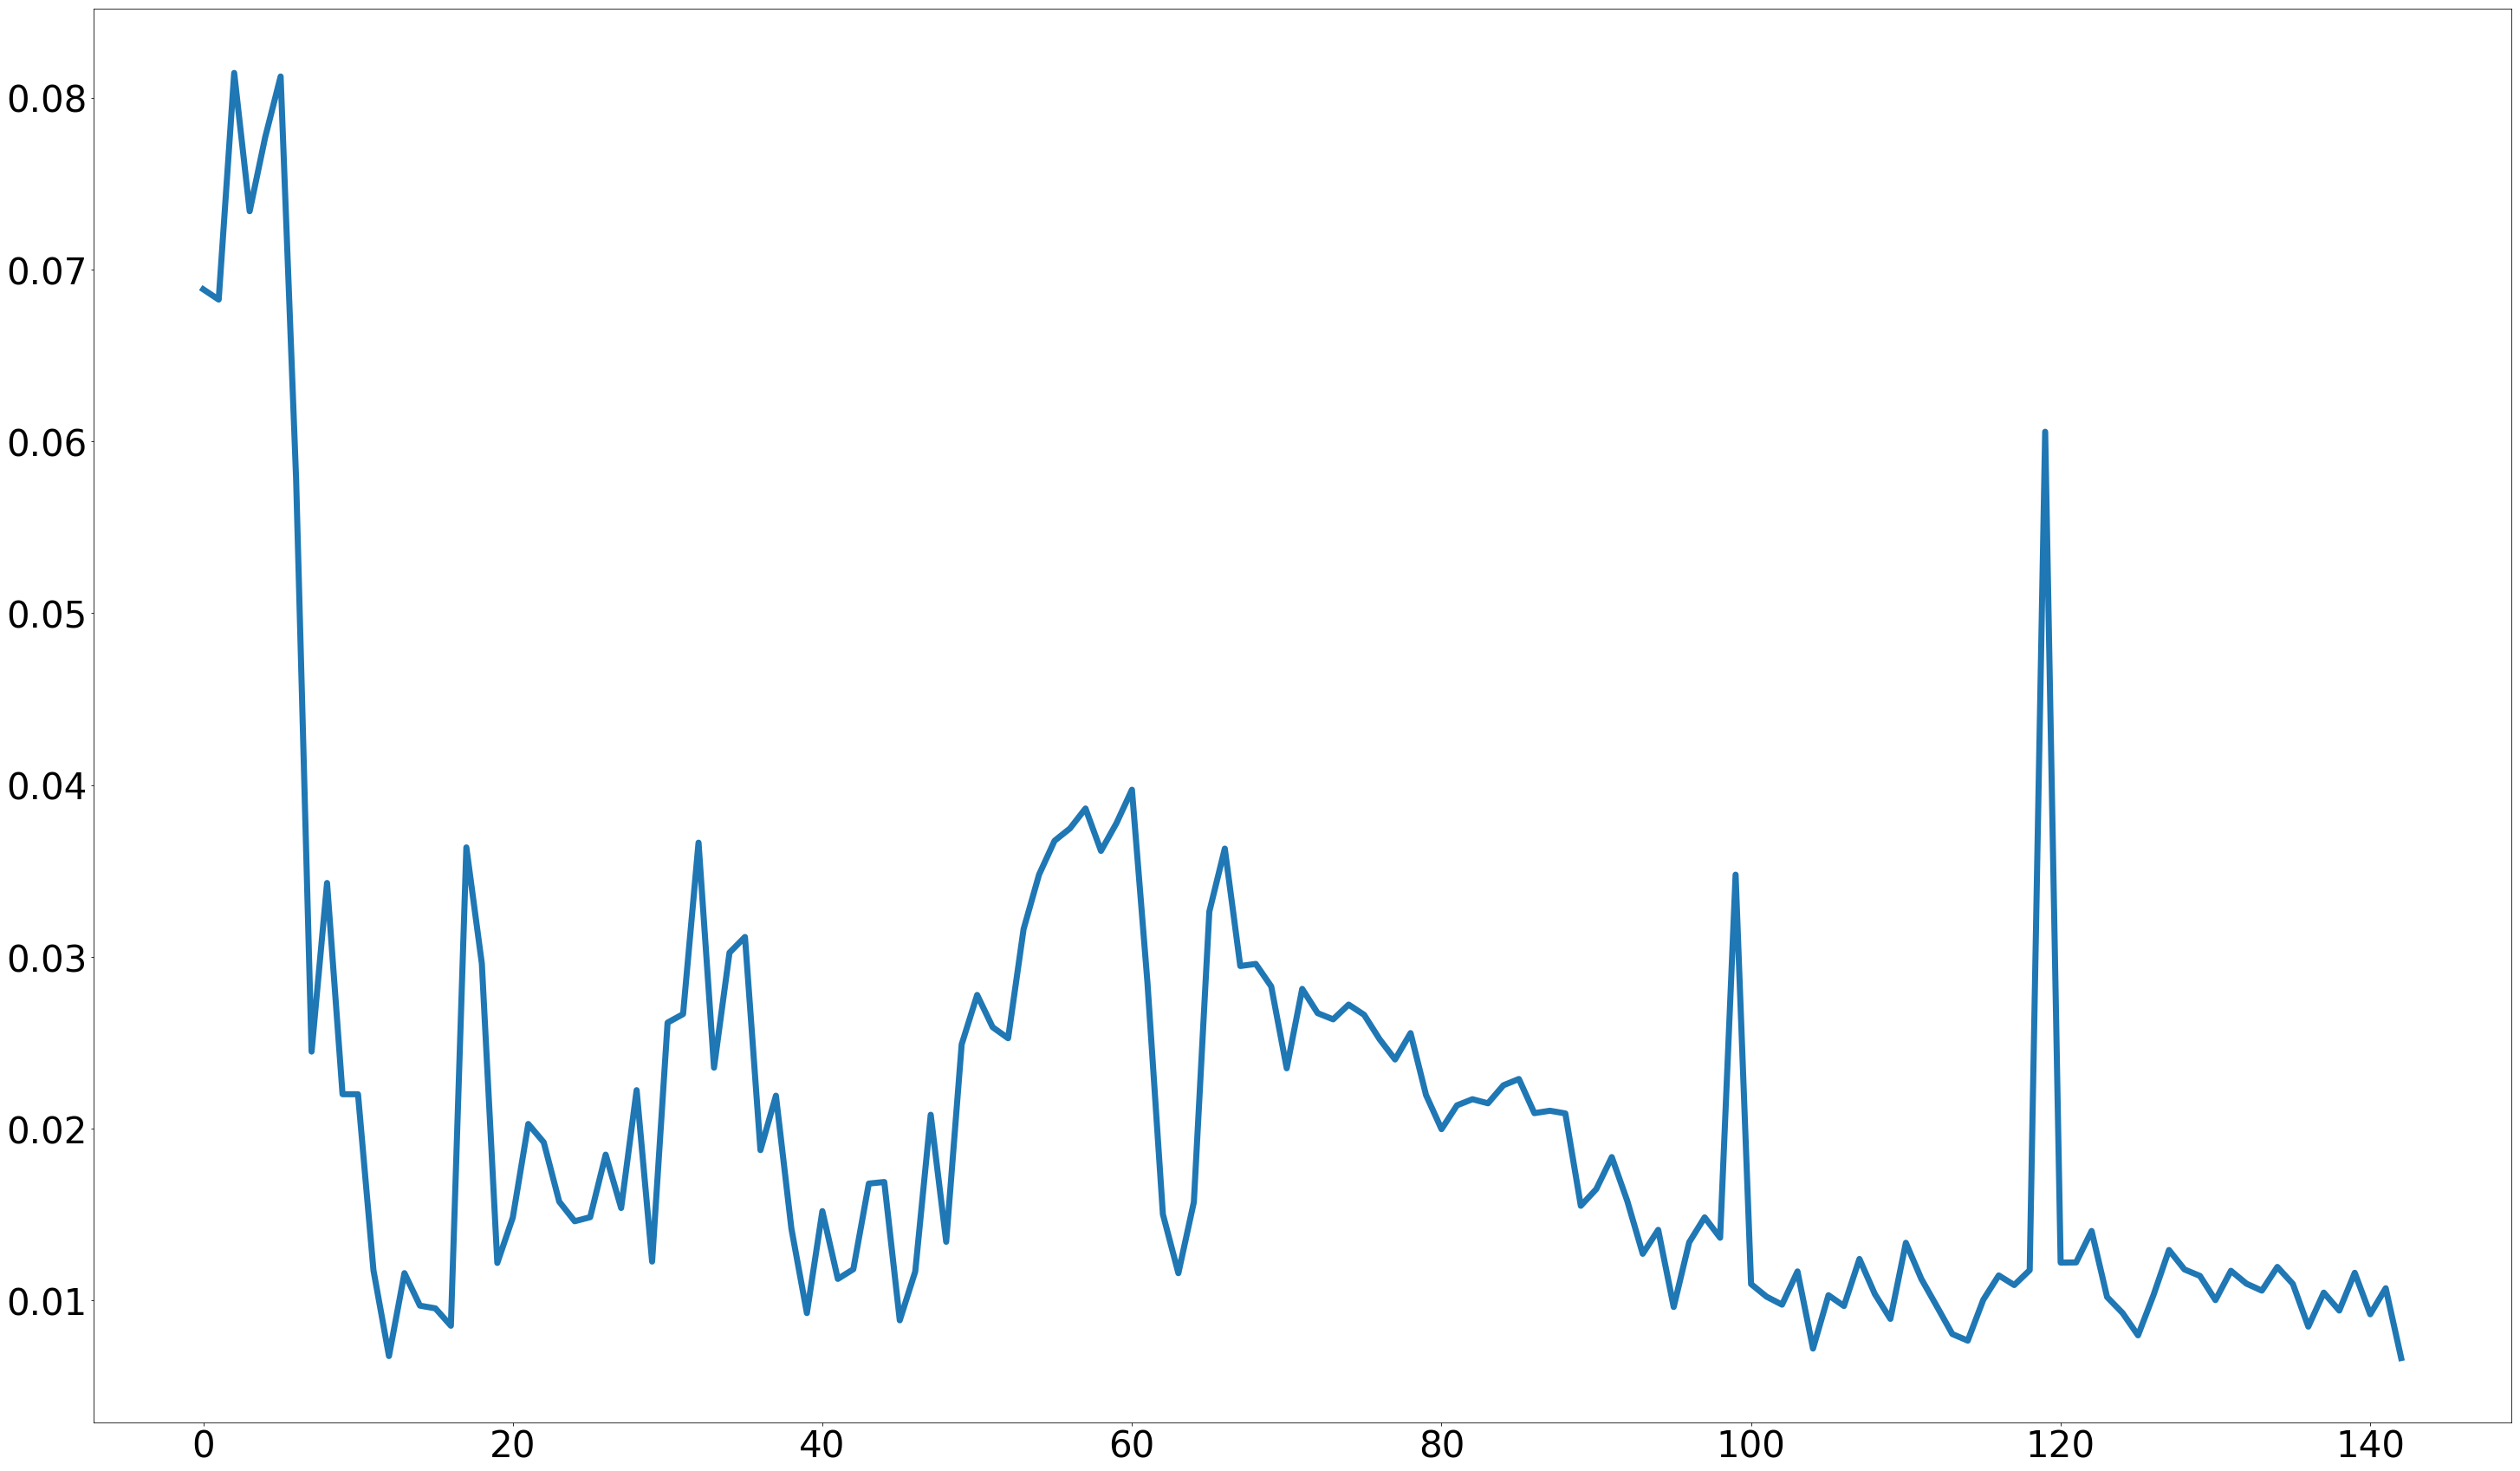

In [72]:
all_accuracies = np.array([np.std([ind.test_acc() for ind in gen]) for gen in exp06.generations])
ax = plt.subplot(111)
ax.plot(all_accuracies)